# Training Networks
In this Notebook, we train networks on the HDF5 Database built. Each network takes in the noisy data, and attempts to predict the optimal circuit parameters that correspond. 

## Custom DataLoader

We need our own dataloader class to extract the correct signals/parameters. We then divide this randomly into training and test groups in a 80:20 ratio.

In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import math  

# Custom Dataloader for our NN from .h5 database
class HDF5Data(Dataset):
    def __init__(self, path_to_h5, ftype):
        self.path_to_h5 = path_to_h5
        with h5py.File(path_to_h5, 'r') as f:
            signaldata = f['NoisySignals'][()]
            
            ftypeValid = False
            if ftype=='LowPass':
                ftypeValid = True
                params = f['LowPass'][()]
            elif ftype=='HighPass':
                ftypeValid = True
                params = f['HighPass'][()]
            elif ftype=='BandPass':
                ftypeValid = True
                params = f['BandPass'][()]
            elif ftype=='ButterworthLowPass':
                ftypeValid = True
                params = f['ButterworthLowPass'][()]
            
            if ftypeValid==False:
                raise ValueError("Given filter name is not one of the options")
            datalen = len(signaldata)
            
        self.signaldata = signaldata
        self.params = params
        self.datalen = datalen

    def __len__(self):
        return self.datalen

    def __getitem__(self, idx):
        return self.signaldata[idx], self.params[idx]

In [36]:
# Splits full dataset into training, test, and validation sets
def loaderSplit(path_to_h5, ftype):
    dataset = HDF5Data(PATH_TO_H5, ftype)

    # Split dataset --> training:test = 80:20
    train_set_size = int(len(dataset) * 0.8)
    test_set_size = len(dataset) - train_set_size
    train_set, test_set = torch.utils.data.random_split(dataset, [train_set_size, test_set_size])

    # Split test --> test:valid = 10:10
    #test_set_size = int(len(test_set)*0.5)
    #valid_set_size = len(test_set) - test_set_size
    #valid_set, test_set = torch.utils.data.random_split(test_set, [valid_set_size, test_set_size])

    # Final Split --> training:test:valid = 80:20:0
    print("Data Points in Training Set:", len(train_set))
    print("Data Points in Test Set:",len(test_set))
    #print("Data Points in Validation Set:",len(valid_set))

    # Using PyTorch DataLoader
    test_loader = DataLoader(test_set, batch_size=100, shuffle=True)
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    #valid_loader = DataLoader(valid_set, batch_size=64, shuffle=True)
    
    return test_loader, train_loader

## Build and Train NN



In [73]:
# Decomposes electric data into frequencies and corresponding strength, multiplies to return single combination
def fftLayer(x):
    dspan = np.linspace(0, len(x), len(x))
    freq = 1/np.max(dspan)*np.arange(len(x))
    fhat = np.fft.fft(x, len(x))
    pow_spec = fhat * np.conj(fhat) / len(x)
    L = np.arange(1, np.floor(len((x))/2), dtype='int')
    print(freq[L])
    print(pow_spec[L])
    return torch.from_numpy(np.multiply(freq[L], pow_spec[L]))
        
class lowNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(lowNN, self).__init__()
        self.l1 = nn.Linear(input_size, 5)
        self.l2 = nn.Linear(5, 5)
        self.l3 = nn.Linear(5, 5)
        self.l4 = nn.Linear(5, 5)
        self.l5 = nn.Linear(5, output_size)
        self.drop = nn.Dropout(p=0.2)
        self.softmax = nn.Softmax(dim=1)
        self.LeakyReLU = nn.LeakyReLU(0.2) 
        
    def forward(self, x):
        x = func.relu(self.LeakyReLU(self.l1(fftLayer(x))))
        #x = self.l2(x)
        #x = self.l3(x)
        x = func.relu(self.l4(x))
        x = self.l5(x)
        return x

# Works well; test set accuracy converges within 100 training epochs ~ 0.004
class highNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(highNN, self).__init__()
        self.l1 = nn.Linear(input_size, 32)
        self.l2 = nn.Linear(32, 32)
        self.l3 = nn.Linear(32, output_size)
    
    def forward(self, x):
        x = func.relu(self.l1(x))
        x = func.relu(self.l2(x))
        x = func.relu(self.l3(x))
        return x

# Test set accuracy plateau ~ 0.09
class bandNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(bandNN, self).__init__()
        self.l1 = nn.Linear(input_size, 32)
        self.l2 = nn.Linear(32, 4)
        self.l3 = nn.Linear(4, 5)
        self.l4 = nn.Linear(5, 4)
        self.l5 = nn.Linear(4, output_size)
        self.drop = nn.Dropout(p=0.2)
        self.softmax = nn.Softmax(dim=1)
        self.LeakyReLU = nn.LeakyReLU(0.2) 
    
    def forward(self, x):
        x = self.LeakyReLU(self.l1(x))
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        return x

class butterlowNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(butterlowNN, self).__init__()
        self.l1 = nn.Linear(input_size, 5)
        self.l2 = nn.Linear(5, 5)
        self.l3 = nn.Linear(5, output_size)
    
    def forward(self, x):
        x = func.relu(self.l1(x))
        #x = self.l2(x)
        x = self.l3(x)
        return x

In [74]:
# Handles training for one epoch
def train_epoch(epoch, network, ftype, train_losses):
    network.train()
    runningloss =0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = mse_loss(output, target)
        loss.backward()
        optimizer.step()
        runningloss += float(loss)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss))#.item()   
        if batch_idx==0 and epoch==1:
            train_losses.append(loss.detach().numpy())
    train_losses.append(runningloss / batch_idx)
    torch.save(network.state_dict(), '../models/%s_model.pt' % ftype)
    torch.save(optimizer.state_dict(), '../models/%s_optimizer.pt' % ftype)
    

# Evaluate network on a test set 
def test(network, test_losses):
    network.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += mse_loss(output, target)
            #pred = output.data.max(1, keepdim=True)[1]
    test_loss /= len(test_loader)#.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}\n'.format(
    test_loss))

# Execute training loop
def train_model(network, ftype, test_losses, train_losses):
    for epoch in range(1, epochs + 1):
        test(network, test_losses)
        train_epoch(epoch, network, ftype=ftype, train_losses=train_losses)
        
def graphTraining(test_losses, train_losses, test_loader):
    test_losses = torch.Tensor(test_losses).numpy()
    train_losses = np.asarray(train_losses)
    tspan = np.linspace(0, test_losses.size, test_losses.size)
    plt.yscale('log')
    plt.plot(tspan, test_losses, label='Test Set Error')
    plt.plot(tspan, train_losses[:-1], label='Train Set Error')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

In [75]:
# Hyperparameters
epochs = 100
log_interval = 10

In [76]:
# Build and train LowPass model 
if __name__=='__main__': 
    PATH_TO_H5 = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/database/RefinedNanoporeFiltering.h5'
    ftype = 'LowPass'
    test_loader, train_loader = loaderSplit(PATH_TO_H5, ftype)
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    # 100 long input vector --> 2 long output vector 
    lowModel = lowNN(100, 2).to(device)
    
    # Optimizer and Loss Function
    learning_rate=5e-3
    optimizer = optim.Adam(lowModel.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    # Training
    train_model(lowModel, ftype=ftype, test_losses=test_losses, train_losses=train_losses)
    
    # Graph MSE vs. Error
    graphTraining(test_losses, train_losses, test_loader)

Data Points in Training Set: 4400
Data Points in Test Set: 1100
Using cpu device
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49]
[[8.98666382e+05+0.j 3.22716290e+01+0.j 3.13909513e+02+0.j ...
  4.11509104e+03+0.j 3.13909513e+02+0.j 3.22716290e+01+0.j]
 [8.59949255e+05+0.j 3.95778333e+02+0.j 8.89544186e+02+0.j ...
  2.57243187e+03+0.j 8.89544186e+02+0.j 3.95778333e+02+0.j]
 [8.87238609e+05+0.j 2.12307486e+03+0.j 2.15520802e+03+0.j ...
  6.91984935e+02+0.j 2.15520802e+03+0.j 2.12307486e+03+0.j]
 ...
 [8.73072358e+05+0.j 1.51922717e+03+0.j 1.77349928e+03+0.j ...
  8.37139643e+02+0.j 1.77349928e+03+0.j 1.51922717e+03+0.j]
 [8.95691909e+05+0.j 2.75979844e+02+0.j 1.68137776e+03+0.j ...
  4.33924239e+02+0.j 1.68137776e+03+0.j 2.75979844e+02+0.j]
 [9.01423722e+05+0.j 4.16208911e+03+0.j 9.2948160

ValueError: operands could not be broadcast together with shapes (49,) (49,100) 

Data Points in Training Set: 7200
Data Points in Test Set: 1800
Using cpu device

Test set: Avg. loss: 3.8090

Train Epoch: 1 [0/7200 (0%)]	Loss: 4.455352
Train Epoch: 1 [320/7200 (4%)]	Loss: 0.404548
Train Epoch: 1 [640/7200 (9%)]	Loss: 0.257097
Train Epoch: 1 [960/7200 (13%)]	Loss: 0.142817
Train Epoch: 1 [1280/7200 (18%)]	Loss: 0.154191
Train Epoch: 1 [1600/7200 (22%)]	Loss: 0.127434
Train Epoch: 1 [1920/7200 (27%)]	Loss: 0.167188
Train Epoch: 1 [2240/7200 (31%)]	Loss: 0.089638
Train Epoch: 1 [2560/7200 (36%)]	Loss: 0.114334
Train Epoch: 1 [2880/7200 (40%)]	Loss: 0.082322
Train Epoch: 1 [3200/7200 (44%)]	Loss: 0.091922
Train Epoch: 1 [3520/7200 (49%)]	Loss: 0.109572
Train Epoch: 1 [3840/7200 (53%)]	Loss: 0.106739
Train Epoch: 1 [4160/7200 (58%)]	Loss: 0.093085
Train Epoch: 1 [4480/7200 (62%)]	Loss: 0.065261
Train Epoch: 1 [4800/7200 (67%)]	Loss: 0.059856
Train Epoch: 1 [5120/7200 (71%)]	Loss: 0.055962
Train Epoch: 1 [5440/7200 (76%)]	Loss: 0.069182
Train Epoch: 1 [5760/7200 (80%)]	L

Train Epoch: 9 [1280/7200 (18%)]	Loss: 0.031703
Train Epoch: 9 [1600/7200 (22%)]	Loss: 0.070029
Train Epoch: 9 [1920/7200 (27%)]	Loss: 0.051930
Train Epoch: 9 [2240/7200 (31%)]	Loss: 0.045642
Train Epoch: 9 [2560/7200 (36%)]	Loss: 0.045135
Train Epoch: 9 [2880/7200 (40%)]	Loss: 0.051685
Train Epoch: 9 [3200/7200 (44%)]	Loss: 0.044257
Train Epoch: 9 [3520/7200 (49%)]	Loss: 0.045786
Train Epoch: 9 [3840/7200 (53%)]	Loss: 0.044766
Train Epoch: 9 [4160/7200 (58%)]	Loss: 0.023397
Train Epoch: 9 [4480/7200 (62%)]	Loss: 0.035266
Train Epoch: 9 [4800/7200 (67%)]	Loss: 0.046414
Train Epoch: 9 [5120/7200 (71%)]	Loss: 0.033774
Train Epoch: 9 [5440/7200 (76%)]	Loss: 0.046103
Train Epoch: 9 [5760/7200 (80%)]	Loss: 0.046947
Train Epoch: 9 [6080/7200 (84%)]	Loss: 0.056130
Train Epoch: 9 [6400/7200 (89%)]	Loss: 0.027882
Train Epoch: 9 [6720/7200 (93%)]	Loss: 0.035478
Train Epoch: 9 [7040/7200 (98%)]	Loss: 0.043816

Test set: Avg. loss: 0.0428

Train Epoch: 10 [0/7200 (0%)]	Loss: 0.039598
Train Epoch: 

Train Epoch: 17 [1920/7200 (27%)]	Loss: 0.031598
Train Epoch: 17 [2240/7200 (31%)]	Loss: 0.048643
Train Epoch: 17 [2560/7200 (36%)]	Loss: 0.047068
Train Epoch: 17 [2880/7200 (40%)]	Loss: 0.054842
Train Epoch: 17 [3200/7200 (44%)]	Loss: 0.038714
Train Epoch: 17 [3520/7200 (49%)]	Loss: 0.038505
Train Epoch: 17 [3840/7200 (53%)]	Loss: 0.031247
Train Epoch: 17 [4160/7200 (58%)]	Loss: 0.030382
Train Epoch: 17 [4480/7200 (62%)]	Loss: 0.036888
Train Epoch: 17 [4800/7200 (67%)]	Loss: 0.030199
Train Epoch: 17 [5120/7200 (71%)]	Loss: 0.039931
Train Epoch: 17 [5440/7200 (76%)]	Loss: 0.042602
Train Epoch: 17 [5760/7200 (80%)]	Loss: 0.042932
Train Epoch: 17 [6080/7200 (84%)]	Loss: 0.029079
Train Epoch: 17 [6400/7200 (89%)]	Loss: 0.053884
Train Epoch: 17 [6720/7200 (93%)]	Loss: 0.038882
Train Epoch: 17 [7040/7200 (98%)]	Loss: 0.038629

Test set: Avg. loss: 0.0355

Train Epoch: 18 [0/7200 (0%)]	Loss: 0.035988
Train Epoch: 18 [320/7200 (4%)]	Loss: 0.073156
Train Epoch: 18 [640/7200 (9%)]	Loss: 0.02929

Train Epoch: 25 [2880/7200 (40%)]	Loss: 0.030184
Train Epoch: 25 [3200/7200 (44%)]	Loss: 0.038522
Train Epoch: 25 [3520/7200 (49%)]	Loss: 0.036901
Train Epoch: 25 [3840/7200 (53%)]	Loss: 0.040747
Train Epoch: 25 [4160/7200 (58%)]	Loss: 0.080592
Train Epoch: 25 [4480/7200 (62%)]	Loss: 0.032012
Train Epoch: 25 [4800/7200 (67%)]	Loss: 0.055343
Train Epoch: 25 [5120/7200 (71%)]	Loss: 0.036214
Train Epoch: 25 [5440/7200 (76%)]	Loss: 0.036679
Train Epoch: 25 [5760/7200 (80%)]	Loss: 0.018117
Train Epoch: 25 [6080/7200 (84%)]	Loss: 0.036293
Train Epoch: 25 [6400/7200 (89%)]	Loss: 0.029504
Train Epoch: 25 [6720/7200 (93%)]	Loss: 0.028309
Train Epoch: 25 [7040/7200 (98%)]	Loss: 0.027301

Test set: Avg. loss: 0.0372

Train Epoch: 26 [0/7200 (0%)]	Loss: 0.026764
Train Epoch: 26 [320/7200 (4%)]	Loss: 0.044870
Train Epoch: 26 [640/7200 (9%)]	Loss: 0.041889
Train Epoch: 26 [960/7200 (13%)]	Loss: 0.018050
Train Epoch: 26 [1280/7200 (18%)]	Loss: 0.029012
Train Epoch: 26 [1600/7200 (22%)]	Loss: 0.028012

Train Epoch: 33 [4480/7200 (62%)]	Loss: 0.021629
Train Epoch: 33 [4800/7200 (67%)]	Loss: 0.028448
Train Epoch: 33 [5120/7200 (71%)]	Loss: 0.024708
Train Epoch: 33 [5440/7200 (76%)]	Loss: 0.048599
Train Epoch: 33 [5760/7200 (80%)]	Loss: 0.035692
Train Epoch: 33 [6080/7200 (84%)]	Loss: 0.024741
Train Epoch: 33 [6400/7200 (89%)]	Loss: 0.040366
Train Epoch: 33 [6720/7200 (93%)]	Loss: 0.028824
Train Epoch: 33 [7040/7200 (98%)]	Loss: 0.035603

Test set: Avg. loss: 0.0306

Train Epoch: 34 [0/7200 (0%)]	Loss: 0.038239
Train Epoch: 34 [320/7200 (4%)]	Loss: 0.032244
Train Epoch: 34 [640/7200 (9%)]	Loss: 0.026360
Train Epoch: 34 [960/7200 (13%)]	Loss: 0.042216
Train Epoch: 34 [1280/7200 (18%)]	Loss: 0.020951
Train Epoch: 34 [1600/7200 (22%)]	Loss: 0.043480
Train Epoch: 34 [1920/7200 (27%)]	Loss: 0.029314
Train Epoch: 34 [2240/7200 (31%)]	Loss: 0.049822
Train Epoch: 34 [2560/7200 (36%)]	Loss: 0.040876
Train Epoch: 34 [2880/7200 (40%)]	Loss: 0.023032
Train Epoch: 34 [3200/7200 (44%)]	Loss: 0.024970

Train Epoch: 41 [5760/7200 (80%)]	Loss: 0.029132
Train Epoch: 41 [6080/7200 (84%)]	Loss: 0.036259
Train Epoch: 41 [6400/7200 (89%)]	Loss: 0.025106
Train Epoch: 41 [6720/7200 (93%)]	Loss: 0.034910
Train Epoch: 41 [7040/7200 (98%)]	Loss: 0.023376

Test set: Avg. loss: 0.0339

Train Epoch: 42 [0/7200 (0%)]	Loss: 0.029495
Train Epoch: 42 [320/7200 (4%)]	Loss: 0.055683
Train Epoch: 42 [640/7200 (9%)]	Loss: 0.036198
Train Epoch: 42 [960/7200 (13%)]	Loss: 0.013866
Train Epoch: 42 [1280/7200 (18%)]	Loss: 0.018057
Train Epoch: 42 [1600/7200 (22%)]	Loss: 0.053151
Train Epoch: 42 [1920/7200 (27%)]	Loss: 0.014769
Train Epoch: 42 [2240/7200 (31%)]	Loss: 0.025030
Train Epoch: 42 [2560/7200 (36%)]	Loss: 0.022339
Train Epoch: 42 [2880/7200 (40%)]	Loss: 0.041284
Train Epoch: 42 [3200/7200 (44%)]	Loss: 0.031414
Train Epoch: 42 [3520/7200 (49%)]	Loss: 0.030131
Train Epoch: 42 [3840/7200 (53%)]	Loss: 0.061879
Train Epoch: 42 [4160/7200 (58%)]	Loss: 0.037561
Train Epoch: 42 [4480/7200 (62%)]	Loss: 0.020895

Train Epoch: 49 [5760/7200 (80%)]	Loss: 0.026830
Train Epoch: 49 [6080/7200 (84%)]	Loss: 0.031441
Train Epoch: 49 [6400/7200 (89%)]	Loss: 0.030325
Train Epoch: 49 [6720/7200 (93%)]	Loss: 0.039784
Train Epoch: 49 [7040/7200 (98%)]	Loss: 0.031129

Test set: Avg. loss: 0.0364

Train Epoch: 50 [0/7200 (0%)]	Loss: 0.037786
Train Epoch: 50 [320/7200 (4%)]	Loss: 0.029484
Train Epoch: 50 [640/7200 (9%)]	Loss: 0.026824
Train Epoch: 50 [960/7200 (13%)]	Loss: 0.020712
Train Epoch: 50 [1280/7200 (18%)]	Loss: 0.023684
Train Epoch: 50 [1600/7200 (22%)]	Loss: 0.034034
Train Epoch: 50 [1920/7200 (27%)]	Loss: 0.027282
Train Epoch: 50 [2240/7200 (31%)]	Loss: 0.029340
Train Epoch: 50 [2560/7200 (36%)]	Loss: 0.025426
Train Epoch: 50 [2880/7200 (40%)]	Loss: 0.030223
Train Epoch: 50 [3200/7200 (44%)]	Loss: 0.031819
Train Epoch: 50 [3520/7200 (49%)]	Loss: 0.021650
Train Epoch: 50 [3840/7200 (53%)]	Loss: 0.033678
Train Epoch: 50 [4160/7200 (58%)]	Loss: 0.021007
Train Epoch: 50 [4480/7200 (62%)]	Loss: 0.032570

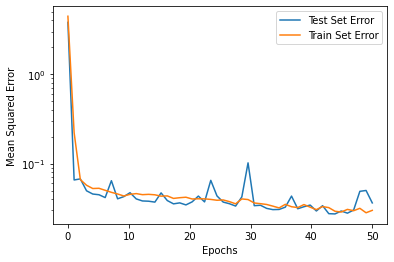

In [238]:
# Build and train HighPass model 
if __name__=='__main__': 
    PATH_TO_H5 = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/database/NanoporeFiltered.h5'
    ftype = 'HighPass'
    test_loader, train_loader = loaderSplit(PATH_TO_H5, ftype)
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    # 100 long input vector --> 2 long output vector 
    highModel = highNN(100, 2).to(device)
    
    # Optimizer and Loss Function
    learning_rate = 0.001
    optimizer = optim.Adam(highModel.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    # Training
    train_model(highModel, ftype=ftype, test_losses = test_losses, train_losses=train_losses)
    
    # Graph epochs vs. MSE
    graphTraining(test_losses, train_losses, test_loader)

Data Points in Training Set: 7200
Data Points in Test Set: 1800
Using cpu device

Test set: Avg. loss: 62.0865

Train Epoch: 1 [0/7200 (0%)]	Loss: 62.805992
Train Epoch: 1 [320/7200 (4%)]	Loss: 60.788479
Train Epoch: 1 [640/7200 (9%)]	Loss: 53.761936
Train Epoch: 1 [960/7200 (13%)]	Loss: 52.465782
Train Epoch: 1 [1280/7200 (18%)]	Loss: 48.035770
Train Epoch: 1 [1600/7200 (22%)]	Loss: 44.659367
Train Epoch: 1 [1920/7200 (27%)]	Loss: 41.748932
Train Epoch: 1 [2240/7200 (31%)]	Loss: 39.381660
Train Epoch: 1 [2560/7200 (36%)]	Loss: 37.134789
Train Epoch: 1 [2880/7200 (40%)]	Loss: 36.172157
Train Epoch: 1 [3200/7200 (44%)]	Loss: 32.696781
Train Epoch: 1 [3520/7200 (49%)]	Loss: 28.278124
Train Epoch: 1 [3840/7200 (53%)]	Loss: 26.993994
Train Epoch: 1 [4160/7200 (58%)]	Loss: 26.256819
Train Epoch: 1 [4480/7200 (62%)]	Loss: 24.657175
Train Epoch: 1 [4800/7200 (67%)]	Loss: 24.635647
Train Epoch: 1 [5120/7200 (71%)]	Loss: 22.006798
Train Epoch: 1 [5440/7200 (76%)]	Loss: 20.551525
Train Epoch: 1 

Train Epoch: 8 [2560/7200 (36%)]	Loss: 1.538875
Train Epoch: 8 [2880/7200 (40%)]	Loss: 1.575597
Train Epoch: 8 [3200/7200 (44%)]	Loss: 1.526917
Train Epoch: 8 [3520/7200 (49%)]	Loss: 1.550799
Train Epoch: 8 [3840/7200 (53%)]	Loss: 1.519142
Train Epoch: 8 [4160/7200 (58%)]	Loss: 1.552693
Train Epoch: 8 [4480/7200 (62%)]	Loss: 1.491299
Train Epoch: 8 [4800/7200 (67%)]	Loss: 1.469578
Train Epoch: 8 [5120/7200 (71%)]	Loss: 1.507475
Train Epoch: 8 [5440/7200 (76%)]	Loss: 1.430489
Train Epoch: 8 [5760/7200 (80%)]	Loss: 1.419640
Train Epoch: 8 [6080/7200 (84%)]	Loss: 1.475813
Train Epoch: 8 [6400/7200 (89%)]	Loss: 1.427293
Train Epoch: 8 [6720/7200 (93%)]	Loss: 1.525037
Train Epoch: 8 [7040/7200 (98%)]	Loss: 1.487395

Test set: Avg. loss: 1.4901

Train Epoch: 9 [0/7200 (0%)]	Loss: 1.479879
Train Epoch: 9 [320/7200 (4%)]	Loss: 1.392174
Train Epoch: 9 [640/7200 (9%)]	Loss: 1.444910
Train Epoch: 9 [960/7200 (13%)]	Loss: 1.391662
Train Epoch: 9 [1280/7200 (18%)]	Loss: 1.422872
Train Epoch: 9 [160

Train Epoch: 16 [1600/7200 (22%)]	Loss: 0.627705
Train Epoch: 16 [1920/7200 (27%)]	Loss: 0.539649
Train Epoch: 16 [2240/7200 (31%)]	Loss: 0.570662
Train Epoch: 16 [2560/7200 (36%)]	Loss: 0.493794
Train Epoch: 16 [2880/7200 (40%)]	Loss: 0.636938
Train Epoch: 16 [3200/7200 (44%)]	Loss: 0.538370
Train Epoch: 16 [3520/7200 (49%)]	Loss: 0.564510
Train Epoch: 16 [3840/7200 (53%)]	Loss: 0.610831
Train Epoch: 16 [4160/7200 (58%)]	Loss: 0.577887
Train Epoch: 16 [4480/7200 (62%)]	Loss: 0.513193
Train Epoch: 16 [4800/7200 (67%)]	Loss: 0.517790
Train Epoch: 16 [5120/7200 (71%)]	Loss: 0.594254
Train Epoch: 16 [5440/7200 (76%)]	Loss: 0.487928
Train Epoch: 16 [5760/7200 (80%)]	Loss: 0.488754
Train Epoch: 16 [6080/7200 (84%)]	Loss: 0.426951
Train Epoch: 16 [6400/7200 (89%)]	Loss: 0.470342
Train Epoch: 16 [6720/7200 (93%)]	Loss: 0.397586
Train Epoch: 16 [7040/7200 (98%)]	Loss: 0.481874

Test set: Avg. loss: 0.5109

Train Epoch: 17 [0/7200 (0%)]	Loss: 0.505071
Train Epoch: 17 [320/7200 (4%)]	Loss: 0.433

Train Epoch: 24 [1600/7200 (22%)]	Loss: 0.190689
Train Epoch: 24 [1920/7200 (27%)]	Loss: 0.193374
Train Epoch: 24 [2240/7200 (31%)]	Loss: 0.357381
Train Epoch: 24 [2560/7200 (36%)]	Loss: 0.190111
Train Epoch: 24 [2880/7200 (40%)]	Loss: 0.139557
Train Epoch: 24 [3200/7200 (44%)]	Loss: 0.297545
Train Epoch: 24 [3520/7200 (49%)]	Loss: 0.161294
Train Epoch: 24 [3840/7200 (53%)]	Loss: 0.198331
Train Epoch: 24 [4160/7200 (58%)]	Loss: 0.223657
Train Epoch: 24 [4480/7200 (62%)]	Loss: 0.171908
Train Epoch: 24 [4800/7200 (67%)]	Loss: 0.295143
Train Epoch: 24 [5120/7200 (71%)]	Loss: 0.221237
Train Epoch: 24 [5440/7200 (76%)]	Loss: 0.267933
Train Epoch: 24 [5760/7200 (80%)]	Loss: 0.138846
Train Epoch: 24 [6080/7200 (84%)]	Loss: 0.231922
Train Epoch: 24 [6400/7200 (89%)]	Loss: 0.299170
Train Epoch: 24 [6720/7200 (93%)]	Loss: 0.171701
Train Epoch: 24 [7040/7200 (98%)]	Loss: 0.274009

Test set: Avg. loss: 0.2362

Train Epoch: 25 [0/7200 (0%)]	Loss: 0.242967
Train Epoch: 25 [320/7200 (4%)]	Loss: 0.240

Train Epoch: 32 [1280/7200 (18%)]	Loss: 0.131138
Train Epoch: 32 [1600/7200 (22%)]	Loss: 0.174876
Train Epoch: 32 [1920/7200 (27%)]	Loss: 0.120372
Train Epoch: 32 [2240/7200 (31%)]	Loss: 0.160993
Train Epoch: 32 [2560/7200 (36%)]	Loss: 0.199540
Train Epoch: 32 [2880/7200 (40%)]	Loss: 0.123486
Train Epoch: 32 [3200/7200 (44%)]	Loss: 0.148262
Train Epoch: 32 [3520/7200 (49%)]	Loss: 0.206860
Train Epoch: 32 [3840/7200 (53%)]	Loss: 0.180656
Train Epoch: 32 [4160/7200 (58%)]	Loss: 0.166889
Train Epoch: 32 [4480/7200 (62%)]	Loss: 0.184115
Train Epoch: 32 [4800/7200 (67%)]	Loss: 0.165183
Train Epoch: 32 [5120/7200 (71%)]	Loss: 0.228233
Train Epoch: 32 [5440/7200 (76%)]	Loss: 0.137999
Train Epoch: 32 [5760/7200 (80%)]	Loss: 0.169692
Train Epoch: 32 [6080/7200 (84%)]	Loss: 0.190215
Train Epoch: 32 [6400/7200 (89%)]	Loss: 0.129256
Train Epoch: 32 [6720/7200 (93%)]	Loss: 0.194976
Train Epoch: 32 [7040/7200 (98%)]	Loss: 0.148343

Test set: Avg. loss: 0.1984

Train Epoch: 33 [0/7200 (0%)]	Loss: 0.2

Train Epoch: 40 [1280/7200 (18%)]	Loss: 0.118271
Train Epoch: 40 [1600/7200 (22%)]	Loss: 0.216234
Train Epoch: 40 [1920/7200 (27%)]	Loss: 0.147448
Train Epoch: 40 [2240/7200 (31%)]	Loss: 0.118461
Train Epoch: 40 [2560/7200 (36%)]	Loss: 0.142265
Train Epoch: 40 [2880/7200 (40%)]	Loss: 0.279362
Train Epoch: 40 [3200/7200 (44%)]	Loss: 0.119823
Train Epoch: 40 [3520/7200 (49%)]	Loss: 0.144828
Train Epoch: 40 [3840/7200 (53%)]	Loss: 0.218417
Train Epoch: 40 [4160/7200 (58%)]	Loss: 0.112276
Train Epoch: 40 [4480/7200 (62%)]	Loss: 0.165708
Train Epoch: 40 [4800/7200 (67%)]	Loss: 0.125364
Train Epoch: 40 [5120/7200 (71%)]	Loss: 0.140973
Train Epoch: 40 [5440/7200 (76%)]	Loss: 0.148814
Train Epoch: 40 [5760/7200 (80%)]	Loss: 0.146717
Train Epoch: 40 [6080/7200 (84%)]	Loss: 0.125298
Train Epoch: 40 [6400/7200 (89%)]	Loss: 0.127896
Train Epoch: 40 [6720/7200 (93%)]	Loss: 0.226344
Train Epoch: 40 [7040/7200 (98%)]	Loss: 0.204163

Test set: Avg. loss: 0.1744

Train Epoch: 41 [0/7200 (0%)]	Loss: 0.2


Test set: Avg. loss: 0.1621

Train Epoch: 48 [0/7200 (0%)]	Loss: 0.152165
Train Epoch: 48 [320/7200 (4%)]	Loss: 0.191673
Train Epoch: 48 [640/7200 (9%)]	Loss: 0.227160
Train Epoch: 48 [960/7200 (13%)]	Loss: 0.129934
Train Epoch: 48 [1280/7200 (18%)]	Loss: 0.079690
Train Epoch: 48 [1600/7200 (22%)]	Loss: 0.107970
Train Epoch: 48 [1920/7200 (27%)]	Loss: 0.104948
Train Epoch: 48 [2240/7200 (31%)]	Loss: 0.109245
Train Epoch: 48 [2560/7200 (36%)]	Loss: 0.174448
Train Epoch: 48 [2880/7200 (40%)]	Loss: 0.102596
Train Epoch: 48 [3200/7200 (44%)]	Loss: 0.081616
Train Epoch: 48 [3520/7200 (49%)]	Loss: 0.119701
Train Epoch: 48 [3840/7200 (53%)]	Loss: 0.192317
Train Epoch: 48 [4160/7200 (58%)]	Loss: 0.210776
Train Epoch: 48 [4480/7200 (62%)]	Loss: 0.232395
Train Epoch: 48 [4800/7200 (67%)]	Loss: 0.146992
Train Epoch: 48 [5120/7200 (71%)]	Loss: 0.154258
Train Epoch: 48 [5440/7200 (76%)]	Loss: 0.115618
Train Epoch: 48 [5760/7200 (80%)]	Loss: 0.091451
Train Epoch: 48 [6080/7200 (84%)]	Loss: 0.109753

Train Epoch: 55 [6080/7200 (84%)]	Loss: 0.088438
Train Epoch: 55 [6400/7200 (89%)]	Loss: 0.097283
Train Epoch: 55 [6720/7200 (93%)]	Loss: 0.168274
Train Epoch: 55 [7040/7200 (98%)]	Loss: 0.110795

Test set: Avg. loss: 0.1534

Train Epoch: 56 [0/7200 (0%)]	Loss: 0.107444
Train Epoch: 56 [320/7200 (4%)]	Loss: 0.106404
Train Epoch: 56 [640/7200 (9%)]	Loss: 0.192901
Train Epoch: 56 [960/7200 (13%)]	Loss: 0.137615
Train Epoch: 56 [1280/7200 (18%)]	Loss: 0.158878
Train Epoch: 56 [1600/7200 (22%)]	Loss: 0.190419
Train Epoch: 56 [1920/7200 (27%)]	Loss: 0.275906
Train Epoch: 56 [2240/7200 (31%)]	Loss: 0.163418
Train Epoch: 56 [2560/7200 (36%)]	Loss: 0.151459
Train Epoch: 56 [2880/7200 (40%)]	Loss: 0.095426
Train Epoch: 56 [3200/7200 (44%)]	Loss: 0.262571
Train Epoch: 56 [3520/7200 (49%)]	Loss: 0.084979
Train Epoch: 56 [3840/7200 (53%)]	Loss: 0.197957
Train Epoch: 56 [4160/7200 (58%)]	Loss: 0.151170
Train Epoch: 56 [4480/7200 (62%)]	Loss: 0.165497
Train Epoch: 56 [4800/7200 (67%)]	Loss: 0.131882

Train Epoch: 63 [3520/7200 (49%)]	Loss: 0.084565
Train Epoch: 63 [3840/7200 (53%)]	Loss: 0.092661
Train Epoch: 63 [4160/7200 (58%)]	Loss: 0.091396
Train Epoch: 63 [4480/7200 (62%)]	Loss: 0.103505
Train Epoch: 63 [4800/7200 (67%)]	Loss: 0.100284
Train Epoch: 63 [5120/7200 (71%)]	Loss: 0.126170
Train Epoch: 63 [5440/7200 (76%)]	Loss: 0.198934
Train Epoch: 63 [5760/7200 (80%)]	Loss: 0.170168
Train Epoch: 63 [6080/7200 (84%)]	Loss: 0.183338
Train Epoch: 63 [6400/7200 (89%)]	Loss: 0.086285
Train Epoch: 63 [6720/7200 (93%)]	Loss: 0.094176
Train Epoch: 63 [7040/7200 (98%)]	Loss: 0.169142

Test set: Avg. loss: 0.1481

Train Epoch: 64 [0/7200 (0%)]	Loss: 0.154968
Train Epoch: 64 [320/7200 (4%)]	Loss: 0.199387
Train Epoch: 64 [640/7200 (9%)]	Loss: 0.155181
Train Epoch: 64 [960/7200 (13%)]	Loss: 0.247953
Train Epoch: 64 [1280/7200 (18%)]	Loss: 0.144287
Train Epoch: 64 [1600/7200 (22%)]	Loss: 0.132213
Train Epoch: 64 [1920/7200 (27%)]	Loss: 0.130560
Train Epoch: 64 [2240/7200 (31%)]	Loss: 0.150329

Train Epoch: 71 [960/7200 (13%)]	Loss: 0.150818
Train Epoch: 71 [1280/7200 (18%)]	Loss: 0.178636
Train Epoch: 71 [1600/7200 (22%)]	Loss: 0.095182
Train Epoch: 71 [1920/7200 (27%)]	Loss: 0.114821
Train Epoch: 71 [2240/7200 (31%)]	Loss: 0.101691
Train Epoch: 71 [2560/7200 (36%)]	Loss: 0.210587
Train Epoch: 71 [2880/7200 (40%)]	Loss: 0.169867
Train Epoch: 71 [3200/7200 (44%)]	Loss: 0.211857
Train Epoch: 71 [3520/7200 (49%)]	Loss: 0.146566
Train Epoch: 71 [3840/7200 (53%)]	Loss: 0.132279
Train Epoch: 71 [4160/7200 (58%)]	Loss: 0.077951
Train Epoch: 71 [4480/7200 (62%)]	Loss: 0.111153
Train Epoch: 71 [4800/7200 (67%)]	Loss: 0.109323
Train Epoch: 71 [5120/7200 (71%)]	Loss: 0.116286
Train Epoch: 71 [5440/7200 (76%)]	Loss: 0.144455
Train Epoch: 71 [5760/7200 (80%)]	Loss: 0.165244
Train Epoch: 71 [6080/7200 (84%)]	Loss: 0.128282
Train Epoch: 71 [6400/7200 (89%)]	Loss: 0.071934
Train Epoch: 71 [6720/7200 (93%)]	Loss: 0.110691
Train Epoch: 71 [7040/7200 (98%)]	Loss: 0.125757

Test set: Avg. loss:


Test set: Avg. loss: 0.1427

Train Epoch: 79 [0/7200 (0%)]	Loss: 0.093346
Train Epoch: 79 [320/7200 (4%)]	Loss: 0.133727
Train Epoch: 79 [640/7200 (9%)]	Loss: 0.086208
Train Epoch: 79 [960/7200 (13%)]	Loss: 0.247653
Train Epoch: 79 [1280/7200 (18%)]	Loss: 0.063350
Train Epoch: 79 [1600/7200 (22%)]	Loss: 0.316223
Train Epoch: 79 [1920/7200 (27%)]	Loss: 0.068622
Train Epoch: 79 [2240/7200 (31%)]	Loss: 0.093797
Train Epoch: 79 [2560/7200 (36%)]	Loss: 0.152998
Train Epoch: 79 [2880/7200 (40%)]	Loss: 0.144960
Train Epoch: 79 [3200/7200 (44%)]	Loss: 0.181215
Train Epoch: 79 [3520/7200 (49%)]	Loss: 0.086687
Train Epoch: 79 [3840/7200 (53%)]	Loss: 0.137601
Train Epoch: 79 [4160/7200 (58%)]	Loss: 0.104726
Train Epoch: 79 [4480/7200 (62%)]	Loss: 0.163423
Train Epoch: 79 [4800/7200 (67%)]	Loss: 0.076483
Train Epoch: 79 [5120/7200 (71%)]	Loss: 0.091715
Train Epoch: 79 [5440/7200 (76%)]	Loss: 0.221386
Train Epoch: 79 [5760/7200 (80%)]	Loss: 0.198366
Train Epoch: 79 [6080/7200 (84%)]	Loss: 0.142269


Test set: Avg. loss: 0.1414

Train Epoch: 87 [0/7200 (0%)]	Loss: 0.100184
Train Epoch: 87 [320/7200 (4%)]	Loss: 0.134420
Train Epoch: 87 [640/7200 (9%)]	Loss: 0.105628
Train Epoch: 87 [960/7200 (13%)]	Loss: 0.113376
Train Epoch: 87 [1280/7200 (18%)]	Loss: 0.071575
Train Epoch: 87 [1600/7200 (22%)]	Loss: 0.105068
Train Epoch: 87 [1920/7200 (27%)]	Loss: 0.141352
Train Epoch: 87 [2240/7200 (31%)]	Loss: 0.119014
Train Epoch: 87 [2560/7200 (36%)]	Loss: 0.145641
Train Epoch: 87 [2880/7200 (40%)]	Loss: 0.125398
Train Epoch: 87 [3200/7200 (44%)]	Loss: 0.124072
Train Epoch: 87 [3520/7200 (49%)]	Loss: 0.074961
Train Epoch: 87 [3840/7200 (53%)]	Loss: 0.110680
Train Epoch: 87 [4160/7200 (58%)]	Loss: 0.106172
Train Epoch: 87 [4480/7200 (62%)]	Loss: 0.149291
Train Epoch: 87 [4800/7200 (67%)]	Loss: 0.063931
Train Epoch: 87 [5120/7200 (71%)]	Loss: 0.168948
Train Epoch: 87 [5440/7200 (76%)]	Loss: 0.095721
Train Epoch: 87 [5760/7200 (80%)]	Loss: 0.083154
Train Epoch: 87 [6080/7200 (84%)]	Loss: 0.067953

Train Epoch: 94 [6720/7200 (93%)]	Loss: 0.083213
Train Epoch: 94 [7040/7200 (98%)]	Loss: 0.071259

Test set: Avg. loss: 0.1401

Train Epoch: 95 [0/7200 (0%)]	Loss: 0.171732
Train Epoch: 95 [320/7200 (4%)]	Loss: 0.107922
Train Epoch: 95 [640/7200 (9%)]	Loss: 0.147352
Train Epoch: 95 [960/7200 (13%)]	Loss: 0.096735
Train Epoch: 95 [1280/7200 (18%)]	Loss: 0.185590
Train Epoch: 95 [1600/7200 (22%)]	Loss: 0.175823
Train Epoch: 95 [1920/7200 (27%)]	Loss: 0.166666
Train Epoch: 95 [2240/7200 (31%)]	Loss: 0.065430
Train Epoch: 95 [2560/7200 (36%)]	Loss: 0.168709
Train Epoch: 95 [2880/7200 (40%)]	Loss: 0.085729
Train Epoch: 95 [3200/7200 (44%)]	Loss: 0.144579
Train Epoch: 95 [3520/7200 (49%)]	Loss: 0.124679
Train Epoch: 95 [3840/7200 (53%)]	Loss: 0.077894
Train Epoch: 95 [4160/7200 (58%)]	Loss: 0.115812
Train Epoch: 95 [4480/7200 (62%)]	Loss: 0.171320
Train Epoch: 95 [4800/7200 (67%)]	Loss: 0.102509
Train Epoch: 95 [5120/7200 (71%)]	Loss: 0.277492
Train Epoch: 95 [5440/7200 (76%)]	Loss: 0.228791

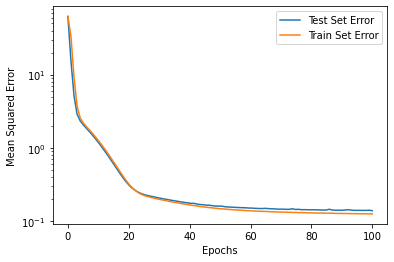

In [222]:
# Build and train BandPass model 
if __name__=='__main__': 
    PATH_TO_H5 = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/database/NanoporeFiltered.h5'
    ftype = 'BandPass'
    test_loader, train_loader = loaderSplit(PATH_TO_H5, ftype)
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    # 100 long input vector --> 2 long output vector 
    bandModel = bandNN(100, 4).to(device)
    
    # Optimizer and Loss Function
    learning_rate = 1e-5
    optimizer = optim.Adam(bandModel.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    # Training
    train_model(bandModel, ftype=ftype, test_losses=test_losses, train_losses=train_losses)
    graphTraining(test_losses, train_losses, test_loader)

In [ ]:
# Build and train BandPass model 
if __name__=='__main__': 
    PATH_TO_H5 = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/database/NanoporeFiltered.h5'
    ftype = 'ButterworthLowPass'
    test_loader, train_loader = loaderSplit(PATH_TO_H5, ftype)
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    # 100 long input vector --> 3 long output vector 
    butterModel = butterlowNN(100, 2).to(device)
    
    # Optimizer and Loss Function
    learning_rate = 1e-4
    optimizer = optim.Adam(butterModel.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    # Training
    train_model(butterModel, ftype=ftype, test_losses=test_losses, train_losses=train_losses)
    graphTraining(test_losses, train_losses, test_loader)

Data Points in Training Set: 7200
Data Points in Test Set: 1800
Using cpu device

Test set: Avg. loss: 685.0684

Train Epoch: 1 [0/7200 (0%)]	Loss: 739.345032
Train Epoch: 1 [320/7200 (4%)]	Loss: 424.610199
Train Epoch: 1 [640/7200 (9%)]	Loss: 274.659729
Train Epoch: 1 [960/7200 (13%)]	Loss: 169.827408
Train Epoch: 1 [1280/7200 (18%)]	Loss: 78.614975
Train Epoch: 1 [1600/7200 (22%)]	Loss: 56.062584
Train Epoch: 1 [1920/7200 (27%)]	Loss: 49.172684
Train Epoch: 1 [2240/7200 (31%)]	Loss: 28.518730
Train Epoch: 1 [2560/7200 (36%)]	Loss: 27.715414
Train Epoch: 1 [2880/7200 (40%)]	Loss: 19.724890
Train Epoch: 1 [3200/7200 (44%)]	Loss: 16.209736
Train Epoch: 1 [3520/7200 (49%)]	Loss: 18.940536
Train Epoch: 1 [3840/7200 (53%)]	Loss: 18.593935
Train Epoch: 1 [4160/7200 (58%)]	Loss: 17.349609
Train Epoch: 1 [4480/7200 (62%)]	Loss: 15.093686
Train Epoch: 1 [4800/7200 (67%)]	Loss: 14.790462
Train Epoch: 1 [5120/7200 (71%)]	Loss: 13.251844
Train Epoch: 1 [5440/7200 (76%)]	Loss: 13.357284
Train Epoc

Train Epoch: 8 [640/7200 (9%)]	Loss: 6.463455
Train Epoch: 8 [960/7200 (13%)]	Loss: 7.843534
Train Epoch: 8 [1280/7200 (18%)]	Loss: 14.255146
Train Epoch: 8 [1600/7200 (22%)]	Loss: 7.553621
Train Epoch: 8 [1920/7200 (27%)]	Loss: 8.912398
Train Epoch: 8 [2240/7200 (31%)]	Loss: 10.631132
Train Epoch: 8 [2560/7200 (36%)]	Loss: 14.024307
Train Epoch: 8 [2880/7200 (40%)]	Loss: 10.753262
Train Epoch: 8 [3200/7200 (44%)]	Loss: 13.755782
Train Epoch: 8 [3520/7200 (49%)]	Loss: 8.076246
Train Epoch: 8 [3840/7200 (53%)]	Loss: 10.331985
Train Epoch: 8 [4160/7200 (58%)]	Loss: 9.412856
Train Epoch: 8 [4480/7200 (62%)]	Loss: 6.808828
Train Epoch: 8 [4800/7200 (67%)]	Loss: 8.661364
Train Epoch: 8 [5120/7200 (71%)]	Loss: 12.800671
Train Epoch: 8 [5440/7200 (76%)]	Loss: 10.919380
Train Epoch: 8 [5760/7200 (80%)]	Loss: 8.275587
Train Epoch: 8 [6080/7200 (84%)]	Loss: 12.205151
Train Epoch: 8 [6400/7200 (89%)]	Loss: 7.094852
Train Epoch: 8 [6720/7200 (93%)]	Loss: 6.718658
Train Epoch: 8 [7040/7200 (98%)]	L

Train Epoch: 15 [3840/7200 (53%)]	Loss: 6.342078
Train Epoch: 15 [4160/7200 (58%)]	Loss: 6.427087
Train Epoch: 15 [4480/7200 (62%)]	Loss: 6.789083
Train Epoch: 15 [4800/7200 (67%)]	Loss: 10.881155
Train Epoch: 15 [5120/7200 (71%)]	Loss: 8.244790
Train Epoch: 15 [5440/7200 (76%)]	Loss: 7.910751
Train Epoch: 15 [5760/7200 (80%)]	Loss: 7.706852
Train Epoch: 15 [6080/7200 (84%)]	Loss: 7.805904
Train Epoch: 15 [6400/7200 (89%)]	Loss: 8.797670
Train Epoch: 15 [6720/7200 (93%)]	Loss: 8.084620
Train Epoch: 15 [7040/7200 (98%)]	Loss: 8.177145

Test set: Avg. loss: 7.3586

Train Epoch: 16 [0/7200 (0%)]	Loss: 7.521758
Train Epoch: 16 [320/7200 (4%)]	Loss: 5.898006
Train Epoch: 16 [640/7200 (9%)]	Loss: 5.808199
Train Epoch: 16 [960/7200 (13%)]	Loss: 7.779785
Train Epoch: 16 [1280/7200 (18%)]	Loss: 6.540352
Train Epoch: 16 [1600/7200 (22%)]	Loss: 7.548774
Train Epoch: 16 [1920/7200 (27%)]	Loss: 7.935488
Train Epoch: 16 [2240/7200 (31%)]	Loss: 9.036848
Train Epoch: 16 [2560/7200 (36%)]	Loss: 7.75116


Test set: Avg. loss: 6.4561

Train Epoch: 23 [0/7200 (0%)]	Loss: 5.898224
Train Epoch: 23 [320/7200 (4%)]	Loss: 7.361050
Train Epoch: 23 [640/7200 (9%)]	Loss: 5.590946
Train Epoch: 23 [960/7200 (13%)]	Loss: 5.794047
Train Epoch: 23 [1280/7200 (18%)]	Loss: 6.864573
Train Epoch: 23 [1600/7200 (22%)]	Loss: 6.996699
Train Epoch: 23 [1920/7200 (27%)]	Loss: 6.282972
Train Epoch: 23 [2240/7200 (31%)]	Loss: 6.319283
Train Epoch: 23 [2560/7200 (36%)]	Loss: 6.439466
Train Epoch: 23 [2880/7200 (40%)]	Loss: 6.796148
Train Epoch: 23 [3200/7200 (44%)]	Loss: 6.764879
Train Epoch: 23 [3520/7200 (49%)]	Loss: 6.654080
Train Epoch: 23 [3840/7200 (53%)]	Loss: 6.881680
Train Epoch: 23 [4160/7200 (58%)]	Loss: 5.231874
Train Epoch: 23 [4480/7200 (62%)]	Loss: 6.770350
Train Epoch: 23 [4800/7200 (67%)]	Loss: 6.853222
Train Epoch: 23 [5120/7200 (71%)]	Loss: 8.172273
Train Epoch: 23 [5440/7200 (76%)]	Loss: 7.038310
Train Epoch: 23 [5760/7200 (80%)]	Loss: 7.426373
Train Epoch: 23 [6080/7200 (84%)]	Loss: 5.720989

Train Epoch: 30 [2880/7200 (40%)]	Loss: 7.734334
Train Epoch: 30 [3200/7200 (44%)]	Loss: 5.103003
Train Epoch: 30 [3520/7200 (49%)]	Loss: 5.113541
Train Epoch: 30 [3840/7200 (53%)]	Loss: 5.782144
Train Epoch: 30 [4160/7200 (58%)]	Loss: 7.308223
Train Epoch: 30 [4480/7200 (62%)]	Loss: 6.336213
Train Epoch: 30 [4800/7200 (67%)]	Loss: 5.980861
Train Epoch: 30 [5120/7200 (71%)]	Loss: 6.079567
Train Epoch: 30 [5440/7200 (76%)]	Loss: 5.937953
Train Epoch: 30 [5760/7200 (80%)]	Loss: 7.421207
Train Epoch: 30 [6080/7200 (84%)]	Loss: 6.863348
Train Epoch: 30 [6400/7200 (89%)]	Loss: 6.385632
Train Epoch: 30 [6720/7200 (93%)]	Loss: 6.771244
Train Epoch: 30 [7040/7200 (98%)]	Loss: 5.024010

Test set: Avg. loss: 6.1272

Train Epoch: 31 [0/7200 (0%)]	Loss: 6.525510
Train Epoch: 31 [320/7200 (4%)]	Loss: 4.864791
Train Epoch: 31 [640/7200 (9%)]	Loss: 7.269194
Train Epoch: 31 [960/7200 (13%)]	Loss: 6.221394
Train Epoch: 31 [1280/7200 (18%)]	Loss: 5.964191
Train Epoch: 31 [1600/7200 (22%)]	Loss: 7.255389

Train Epoch: 37 [5120/7200 (71%)]	Loss: 5.872677
Train Epoch: 37 [5440/7200 (76%)]	Loss: 5.712422
Train Epoch: 37 [5760/7200 (80%)]	Loss: 5.254141
Train Epoch: 37 [6080/7200 (84%)]	Loss: 7.074935
Train Epoch: 37 [6400/7200 (89%)]	Loss: 5.159262
Train Epoch: 37 [6720/7200 (93%)]	Loss: 5.399379
Train Epoch: 37 [7040/7200 (98%)]	Loss: 5.036895

Test set: Avg. loss: 6.0152

Train Epoch: 38 [0/7200 (0%)]	Loss: 6.154454
Train Epoch: 38 [320/7200 (4%)]	Loss: 6.695486
Train Epoch: 38 [640/7200 (9%)]	Loss: 6.473467
Train Epoch: 38 [960/7200 (13%)]	Loss: 5.698011
Train Epoch: 38 [1280/7200 (18%)]	Loss: 6.051399
Train Epoch: 38 [1600/7200 (22%)]	Loss: 6.660609
Train Epoch: 38 [1920/7200 (27%)]	Loss: 6.320533
Train Epoch: 38 [2240/7200 (31%)]	Loss: 6.286123
Train Epoch: 38 [2560/7200 (36%)]	Loss: 6.630706
Train Epoch: 38 [2880/7200 (40%)]	Loss: 6.672399
Train Epoch: 38 [3200/7200 (44%)]	Loss: 5.777471
Train Epoch: 38 [3520/7200 (49%)]	Loss: 6.120854
Train Epoch: 38 [3840/7200 (53%)]	Loss: 5.759868


Test set: Avg. loss: 6.0382

Train Epoch: 45 [0/7200 (0%)]	Loss: 7.072161
Train Epoch: 45 [320/7200 (4%)]	Loss: 5.821579
Train Epoch: 45 [640/7200 (9%)]	Loss: 6.758852
Train Epoch: 45 [960/7200 (13%)]	Loss: 6.446676
Train Epoch: 45 [1280/7200 (18%)]	Loss: 6.253664
Train Epoch: 45 [1600/7200 (22%)]	Loss: 4.951192
Train Epoch: 45 [1920/7200 (27%)]	Loss: 6.435815
Train Epoch: 45 [2240/7200 (31%)]	Loss: 5.688105
Train Epoch: 45 [2560/7200 (36%)]	Loss: 5.737081
Train Epoch: 45 [2880/7200 (40%)]	Loss: 6.158917
Train Epoch: 45 [3200/7200 (44%)]	Loss: 6.224427
Train Epoch: 45 [3520/7200 (49%)]	Loss: 4.974207
Train Epoch: 45 [3840/7200 (53%)]	Loss: 6.944763
Train Epoch: 45 [4160/7200 (58%)]	Loss: 5.146481
Train Epoch: 45 [4480/7200 (62%)]	Loss: 6.812755
Train Epoch: 45 [4800/7200 (67%)]	Loss: 6.356239
Train Epoch: 45 [5120/7200 (71%)]	Loss: 6.359912
Train Epoch: 45 [5440/7200 (76%)]	Loss: 6.599322
Train Epoch: 45 [5760/7200 (80%)]	Loss: 4.641854
Train Epoch: 45 [6080/7200 (84%)]	Loss: 5.545110

Train Epoch: 52 [3840/7200 (53%)]	Loss: 5.558640
Train Epoch: 52 [4160/7200 (58%)]	Loss: 6.470963
Train Epoch: 52 [4480/7200 (62%)]	Loss: 6.600929
Train Epoch: 52 [4800/7200 (67%)]	Loss: 5.539260
Train Epoch: 52 [5120/7200 (71%)]	Loss: 5.295258
Train Epoch: 52 [5440/7200 (76%)]	Loss: 5.287674
Train Epoch: 52 [5760/7200 (80%)]	Loss: 6.737409
Train Epoch: 52 [6080/7200 (84%)]	Loss: 7.109090
Train Epoch: 52 [6400/7200 (89%)]	Loss: 6.315563
Train Epoch: 52 [6720/7200 (93%)]	Loss: 6.057763
Train Epoch: 52 [7040/7200 (98%)]	Loss: 6.074764

Test set: Avg. loss: 5.9644

Train Epoch: 53 [0/7200 (0%)]	Loss: 5.808595
Train Epoch: 53 [320/7200 (4%)]	Loss: 6.126373
Train Epoch: 53 [640/7200 (9%)]	Loss: 6.072068
Train Epoch: 53 [960/7200 (13%)]	Loss: 6.183372
Train Epoch: 53 [1280/7200 (18%)]	Loss: 6.023549
Train Epoch: 53 [1600/7200 (22%)]	Loss: 6.031160
Train Epoch: 53 [1920/7200 (27%)]	Loss: 6.388392
Train Epoch: 53 [2240/7200 (31%)]	Loss: 6.417528
Train Epoch: 53 [2560/7200 (36%)]	Loss: 5.643452


Test set: Avg. loss: 5.9242

Train Epoch: 60 [0/7200 (0%)]	Loss: 4.859282
Train Epoch: 60 [320/7200 (4%)]	Loss: 5.977812
Train Epoch: 60 [640/7200 (9%)]	Loss: 6.132891
Train Epoch: 60 [960/7200 (13%)]	Loss: 6.303352
Train Epoch: 60 [1280/7200 (18%)]	Loss: 5.833879
Train Epoch: 60 [1600/7200 (22%)]	Loss: 6.173465
Train Epoch: 60 [1920/7200 (27%)]	Loss: 7.299074
Train Epoch: 60 [2240/7200 (31%)]	Loss: 4.902688
Train Epoch: 60 [2560/7200 (36%)]	Loss: 5.643940
Train Epoch: 60 [2880/7200 (40%)]	Loss: 6.448866
Train Epoch: 60 [3200/7200 (44%)]	Loss: 6.787245
Train Epoch: 60 [3520/7200 (49%)]	Loss: 6.916540
Train Epoch: 60 [3840/7200 (53%)]	Loss: 5.567915
Train Epoch: 60 [4160/7200 (58%)]	Loss: 5.823316
Train Epoch: 60 [4480/7200 (62%)]	Loss: 6.099782
Train Epoch: 60 [4800/7200 (67%)]	Loss: 4.638524
Train Epoch: 60 [5120/7200 (71%)]	Loss: 4.879685
Train Epoch: 60 [5440/7200 (76%)]	Loss: 5.266018
Train Epoch: 60 [5760/7200 (80%)]	Loss: 5.149803
Train Epoch: 60 [6080/7200 (84%)]	Loss: 6.633578

Train Epoch: 67 [3840/7200 (53%)]	Loss: 6.546777
Train Epoch: 67 [4160/7200 (58%)]	Loss: 6.536158
Train Epoch: 67 [4480/7200 (62%)]	Loss: 4.949608
Train Epoch: 67 [4800/7200 (67%)]	Loss: 5.842463
Train Epoch: 67 [5120/7200 (71%)]	Loss: 6.198109
Train Epoch: 67 [5440/7200 (76%)]	Loss: 6.464067
Train Epoch: 67 [5760/7200 (80%)]	Loss: 5.706858
Train Epoch: 67 [6080/7200 (84%)]	Loss: 6.199826
Train Epoch: 67 [6400/7200 (89%)]	Loss: 5.856465
Train Epoch: 67 [6720/7200 (93%)]	Loss: 5.694077
Train Epoch: 67 [7040/7200 (98%)]	Loss: 4.750926

Test set: Avg. loss: 6.0065

Train Epoch: 68 [0/7200 (0%)]	Loss: 6.335185
Train Epoch: 68 [320/7200 (4%)]	Loss: 5.953316
Train Epoch: 68 [640/7200 (9%)]	Loss: 5.713300
Train Epoch: 68 [960/7200 (13%)]	Loss: 5.490032
Train Epoch: 68 [1280/7200 (18%)]	Loss: 5.627897
Train Epoch: 68 [1600/7200 (22%)]	Loss: 5.139765
Train Epoch: 68 [1920/7200 (27%)]	Loss: 6.230951
Train Epoch: 68 [2240/7200 (31%)]	Loss: 6.717681
Train Epoch: 68 [2560/7200 (36%)]	Loss: 6.715798


Test set: Avg. loss: 5.9485

Train Epoch: 75 [0/7200 (0%)]	Loss: 6.763039
Train Epoch: 75 [320/7200 (4%)]	Loss: 6.276932
Train Epoch: 75 [640/7200 (9%)]	Loss: 5.996392
Train Epoch: 75 [960/7200 (13%)]	Loss: 6.430571
Train Epoch: 75 [1280/7200 (18%)]	Loss: 6.200199
Train Epoch: 75 [1600/7200 (22%)]	Loss: 6.726958
Train Epoch: 75 [1920/7200 (27%)]	Loss: 5.008381
Train Epoch: 75 [2240/7200 (31%)]	Loss: 6.206684
Train Epoch: 75 [2560/7200 (36%)]	Loss: 5.698832
Train Epoch: 75 [2880/7200 (40%)]	Loss: 6.516512
Train Epoch: 75 [3200/7200 (44%)]	Loss: 5.845896
Train Epoch: 75 [3520/7200 (49%)]	Loss: 7.078728
Train Epoch: 75 [3840/7200 (53%)]	Loss: 6.627675
Train Epoch: 75 [4160/7200 (58%)]	Loss: 7.093969
Train Epoch: 75 [4480/7200 (62%)]	Loss: 4.935852
Train Epoch: 75 [4800/7200 (67%)]	Loss: 5.975472
Train Epoch: 75 [5120/7200 (71%)]	Loss: 6.072246
Train Epoch: 75 [5440/7200 (76%)]	Loss: 6.739881
Train Epoch: 75 [5760/7200 (80%)]	Loss: 6.030152
Train Epoch: 75 [6080/7200 (84%)]	Loss: 6.077912

Train Epoch: 82 [3840/7200 (53%)]	Loss: 6.491923
Train Epoch: 82 [4160/7200 (58%)]	Loss: 5.586374
Train Epoch: 82 [4480/7200 (62%)]	Loss: 6.148752
Train Epoch: 82 [4800/7200 (67%)]	Loss: 5.144887
Train Epoch: 82 [5120/7200 (71%)]	Loss: 6.325109
Train Epoch: 82 [5440/7200 (76%)]	Loss: 5.855160
Train Epoch: 82 [5760/7200 (80%)]	Loss: 5.619884
Train Epoch: 82 [6080/7200 (84%)]	Loss: 6.008603
Train Epoch: 82 [6400/7200 (89%)]	Loss: 6.653534
Train Epoch: 82 [6720/7200 (93%)]	Loss: 5.382258
Train Epoch: 82 [7040/7200 (98%)]	Loss: 6.022890

Test set: Avg. loss: 5.9367

Train Epoch: 83 [0/7200 (0%)]	Loss: 6.812977
Train Epoch: 83 [320/7200 (4%)]	Loss: 6.705014
Train Epoch: 83 [640/7200 (9%)]	Loss: 6.353442
Train Epoch: 83 [960/7200 (13%)]	Loss: 5.419318
Train Epoch: 83 [1280/7200 (18%)]	Loss: 5.701796
Train Epoch: 83 [1600/7200 (22%)]	Loss: 6.542664
Train Epoch: 83 [1920/7200 (27%)]	Loss: 5.515795
Train Epoch: 83 [2240/7200 (31%)]	Loss: 6.498298
Train Epoch: 83 [2560/7200 (36%)]	Loss: 4.832328

Train Epoch: 89 [7040/7200 (98%)]	Loss: 7.238184

Test set: Avg. loss: 5.9027

Train Epoch: 90 [0/7200 (0%)]	Loss: 5.422909
Train Epoch: 90 [320/7200 (4%)]	Loss: 6.540423
Train Epoch: 90 [640/7200 (9%)]	Loss: 6.859478
Train Epoch: 90 [960/7200 (13%)]	Loss: 6.013987
Train Epoch: 90 [1280/7200 (18%)]	Loss: 6.240862
Train Epoch: 90 [1600/7200 (22%)]	Loss: 6.538847
Train Epoch: 90 [1920/7200 (27%)]	Loss: 5.865278
Train Epoch: 90 [2240/7200 (31%)]	Loss: 6.469444
Train Epoch: 90 [2560/7200 (36%)]	Loss: 5.203589
Train Epoch: 90 [2880/7200 (40%)]	Loss: 6.490855
Train Epoch: 90 [3200/7200 (44%)]	Loss: 7.379351
Train Epoch: 90 [3520/7200 (49%)]	Loss: 6.303132
Train Epoch: 90 [3840/7200 (53%)]	Loss: 5.808986
Train Epoch: 90 [4160/7200 (58%)]	Loss: 6.439924
Train Epoch: 90 [4480/7200 (62%)]	Loss: 4.858226
Train Epoch: 90 [4800/7200 (67%)]	Loss: 5.566481
Train Epoch: 90 [5120/7200 (71%)]	Loss: 5.143625
Train Epoch: 90 [5440/7200 (76%)]	Loss: 7.181915
Train Epoch: 90 [5760/7200 (80%)]	Loss: 6.348310

Train Epoch: 97 [3840/7200 (53%)]	Loss: 6.720555
Train Epoch: 97 [4160/7200 (58%)]	Loss: 7.084331
Train Epoch: 97 [4480/7200 (62%)]	Loss: 5.086925
Train Epoch: 97 [4800/7200 (67%)]	Loss: 6.515745
Train Epoch: 97 [5120/7200 (71%)]	Loss: 5.461359
Train Epoch: 97 [5440/7200 (76%)]	Loss: 6.125356
Train Epoch: 97 [5760/7200 (80%)]	Loss: 4.920970
Train Epoch: 97 [6080/7200 (84%)]	Loss: 6.647288
Train Epoch: 97 [6400/7200 (89%)]	Loss: 5.978283
Train Epoch: 97 [6720/7200 (93%)]	Loss: 5.412798
Train Epoch: 97 [7040/7200 (98%)]	Loss: 5.243015

Test set: Avg. loss: 5.9099

Train Epoch: 98 [0/7200 (0%)]	Loss: 5.908162
Train Epoch: 98 [320/7200 (4%)]	Loss: 5.369098
Train Epoch: 98 [640/7200 (9%)]	Loss: 5.837818
Train Epoch: 98 [960/7200 (13%)]	Loss: 5.597967
Train Epoch: 98 [1280/7200 (18%)]	Loss: 5.732268
Train Epoch: 98 [1600/7200 (22%)]	Loss: 6.339431
Train Epoch: 98 [1920/7200 (27%)]	Loss: 6.185719
Train Epoch: 98 [2240/7200 (31%)]	Loss: 6.126467
Train Epoch: 98 [2560/7200 (36%)]	Loss: 6.336122

Train Epoch: 105 [0/7200 (0%)]	Loss: 5.877222
Train Epoch: 105 [320/7200 (4%)]	Loss: 5.743004
Train Epoch: 105 [640/7200 (9%)]	Loss: 6.091902
Train Epoch: 105 [960/7200 (13%)]	Loss: 5.720591
Train Epoch: 105 [1280/7200 (18%)]	Loss: 5.823832
Train Epoch: 105 [1600/7200 (22%)]	Loss: 5.831521
Train Epoch: 105 [1920/7200 (27%)]	Loss: 5.696812
Train Epoch: 105 [2240/7200 (31%)]	Loss: 7.279613
Train Epoch: 105 [2560/7200 (36%)]	Loss: 5.930173
Train Epoch: 105 [2880/7200 (40%)]	Loss: 6.491687
Train Epoch: 105 [3200/7200 (44%)]	Loss: 6.111156
Train Epoch: 105 [3520/7200 (49%)]	Loss: 6.276148
Train Epoch: 105 [3840/7200 (53%)]	Loss: 5.919983
Train Epoch: 105 [4160/7200 (58%)]	Loss: 5.425784
Train Epoch: 105 [4480/7200 (62%)]	Loss: 5.881736
Train Epoch: 105 [4800/7200 (67%)]	Loss: 6.236870
Train Epoch: 105 [5120/7200 (71%)]	Loss: 5.832839
Train Epoch: 105 [5440/7200 (76%)]	Loss: 5.767125
Train Epoch: 105 [5760/7200 (80%)]	Loss: 6.560132
Train Epoch: 105 [6080/7200 (84%)]	Loss: 6.058767
Train Epo

Train Epoch: 112 [4160/7200 (58%)]	Loss: 5.834771
Train Epoch: 112 [4480/7200 (62%)]	Loss: 5.709128
Train Epoch: 112 [4800/7200 (67%)]	Loss: 6.356337
Train Epoch: 112 [5120/7200 (71%)]	Loss: 6.051747
Train Epoch: 112 [5440/7200 (76%)]	Loss: 6.714595
Train Epoch: 112 [5760/7200 (80%)]	Loss: 6.620677
Train Epoch: 112 [6080/7200 (84%)]	Loss: 5.274438
Train Epoch: 112 [6400/7200 (89%)]	Loss: 5.809804
Train Epoch: 112 [6720/7200 (93%)]	Loss: 6.473891
Train Epoch: 112 [7040/7200 (98%)]	Loss: 6.025498

Test set: Avg. loss: 5.8951

Train Epoch: 113 [0/7200 (0%)]	Loss: 6.729085
Train Epoch: 113 [320/7200 (4%)]	Loss: 6.578038
Train Epoch: 113 [640/7200 (9%)]	Loss: 5.334638
Train Epoch: 113 [960/7200 (13%)]	Loss: 5.991288
Train Epoch: 113 [1280/7200 (18%)]	Loss: 4.887457
Train Epoch: 113 [1600/7200 (22%)]	Loss: 5.630432
Train Epoch: 113 [1920/7200 (27%)]	Loss: 5.802279
Train Epoch: 113 [2240/7200 (31%)]	Loss: 6.036201
Train Epoch: 113 [2560/7200 (36%)]	Loss: 6.478033
Train Epoch: 113 [2880/7200 (

Train Epoch: 120 [960/7200 (13%)]	Loss: 6.578569
Train Epoch: 120 [1280/7200 (18%)]	Loss: 6.641889
Train Epoch: 120 [1600/7200 (22%)]	Loss: 5.662209
Train Epoch: 120 [1920/7200 (27%)]	Loss: 6.967890
Train Epoch: 120 [2240/7200 (31%)]	Loss: 6.195369
Train Epoch: 120 [2560/7200 (36%)]	Loss: 5.138103
Train Epoch: 120 [2880/7200 (40%)]	Loss: 6.090920
Train Epoch: 120 [3200/7200 (44%)]	Loss: 6.221271
Train Epoch: 120 [3520/7200 (49%)]	Loss: 5.035419
Train Epoch: 120 [3840/7200 (53%)]	Loss: 5.395631
Train Epoch: 120 [4160/7200 (58%)]	Loss: 6.480829
Train Epoch: 120 [4480/7200 (62%)]	Loss: 5.067204
Train Epoch: 120 [4800/7200 (67%)]	Loss: 5.608364
Train Epoch: 120 [5120/7200 (71%)]	Loss: 7.599815
Train Epoch: 120 [5440/7200 (76%)]	Loss: 6.578461
Train Epoch: 120 [5760/7200 (80%)]	Loss: 6.262043
Train Epoch: 120 [6080/7200 (84%)]	Loss: 5.699961
Train Epoch: 120 [6400/7200 (89%)]	Loss: 5.924223
Train Epoch: 120 [6720/7200 (93%)]	Loss: 6.551458
Train Epoch: 120 [7040/7200 (98%)]	Loss: 5.508365



Train Epoch: 127 [5440/7200 (76%)]	Loss: 6.073412
Train Epoch: 127 [5760/7200 (80%)]	Loss: 6.833846
Train Epoch: 127 [6080/7200 (84%)]	Loss: 5.194332
Train Epoch: 127 [6400/7200 (89%)]	Loss: 6.766418
Train Epoch: 127 [6720/7200 (93%)]	Loss: 5.834824
Train Epoch: 127 [7040/7200 (98%)]	Loss: 6.173923

Test set: Avg. loss: 5.9039

Train Epoch: 128 [0/7200 (0%)]	Loss: 7.083601
Train Epoch: 128 [320/7200 (4%)]	Loss: 5.867123
Train Epoch: 128 [640/7200 (9%)]	Loss: 6.277674
Train Epoch: 128 [960/7200 (13%)]	Loss: 6.216364
Train Epoch: 128 [1280/7200 (18%)]	Loss: 5.598743
Train Epoch: 128 [1600/7200 (22%)]	Loss: 6.265133
Train Epoch: 128 [1920/7200 (27%)]	Loss: 5.411773
Train Epoch: 128 [2240/7200 (31%)]	Loss: 6.807475
Train Epoch: 128 [2560/7200 (36%)]	Loss: 6.728181
Train Epoch: 128 [2880/7200 (40%)]	Loss: 5.764679
Train Epoch: 128 [3200/7200 (44%)]	Loss: 6.421187
Train Epoch: 128 [3520/7200 (49%)]	Loss: 7.051651
Train Epoch: 128 [3840/7200 (53%)]	Loss: 5.045807
Train Epoch: 128 [4160/7200 (

Train Epoch: 135 [2240/7200 (31%)]	Loss: 5.631536
Train Epoch: 135 [2560/7200 (36%)]	Loss: 5.804596
Train Epoch: 135 [2880/7200 (40%)]	Loss: 5.882102
Train Epoch: 135 [3200/7200 (44%)]	Loss: 5.604996
Train Epoch: 135 [3520/7200 (49%)]	Loss: 6.081161
Train Epoch: 135 [3840/7200 (53%)]	Loss: 6.530898
Train Epoch: 135 [4160/7200 (58%)]	Loss: 4.900423
Train Epoch: 135 [4480/7200 (62%)]	Loss: 6.202774
Train Epoch: 135 [4800/7200 (67%)]	Loss: 6.318835
Train Epoch: 135 [5120/7200 (71%)]	Loss: 5.432744
Train Epoch: 135 [5440/7200 (76%)]	Loss: 6.473520
Train Epoch: 135 [5760/7200 (80%)]	Loss: 6.744060
Train Epoch: 135 [6080/7200 (84%)]	Loss: 6.194206
Train Epoch: 135 [6400/7200 (89%)]	Loss: 6.870370
Train Epoch: 135 [6720/7200 (93%)]	Loss: 6.421323
Train Epoch: 135 [7040/7200 (98%)]	Loss: 6.442110

Test set: Avg. loss: 5.9038

Train Epoch: 136 [0/7200 (0%)]	Loss: 6.423994
Train Epoch: 136 [320/7200 (4%)]	Loss: 6.737007
Train Epoch: 136 [640/7200 (9%)]	Loss: 5.461498
Train Epoch: 136 [960/7200 (

Train Epoch: 142 [6400/7200 (89%)]	Loss: 5.854192
Train Epoch: 142 [6720/7200 (93%)]	Loss: 5.093394
Train Epoch: 142 [7040/7200 (98%)]	Loss: 6.490931

Test set: Avg. loss: 5.8922

Train Epoch: 143 [0/7200 (0%)]	Loss: 5.654726
Train Epoch: 143 [320/7200 (4%)]	Loss: 6.912962
Train Epoch: 143 [640/7200 (9%)]	Loss: 5.520136
Train Epoch: 143 [960/7200 (13%)]	Loss: 7.004508
Train Epoch: 143 [1280/7200 (18%)]	Loss: 6.793877
Train Epoch: 143 [1600/7200 (22%)]	Loss: 5.153090
Train Epoch: 143 [1920/7200 (27%)]	Loss: 5.700234
Train Epoch: 143 [2240/7200 (31%)]	Loss: 5.979472
Train Epoch: 143 [2560/7200 (36%)]	Loss: 7.188323
Train Epoch: 143 [2880/7200 (40%)]	Loss: 5.099044
Train Epoch: 143 [3200/7200 (44%)]	Loss: 5.528099
Train Epoch: 143 [3520/7200 (49%)]	Loss: 6.637473
Train Epoch: 143 [3840/7200 (53%)]	Loss: 5.794699
Train Epoch: 143 [4160/7200 (58%)]	Loss: 6.275860
Train Epoch: 143 [4480/7200 (62%)]	Loss: 5.436082
Train Epoch: 143 [4800/7200 (67%)]	Loss: 6.275087
Train Epoch: 143 [5120/7200 (

Train Epoch: 150 [3200/7200 (44%)]	Loss: 6.429378
Train Epoch: 150 [3520/7200 (49%)]	Loss: 6.998578
Train Epoch: 150 [3840/7200 (53%)]	Loss: 5.950788
Train Epoch: 150 [4160/7200 (58%)]	Loss: 5.611662
Train Epoch: 150 [4480/7200 (62%)]	Loss: 6.370019
Train Epoch: 150 [4800/7200 (67%)]	Loss: 5.647062
Train Epoch: 150 [5120/7200 (71%)]	Loss: 6.539474
Train Epoch: 150 [5440/7200 (76%)]	Loss: 4.781075
Train Epoch: 150 [5760/7200 (80%)]	Loss: 6.748789
Train Epoch: 150 [6080/7200 (84%)]	Loss: 4.957015
Train Epoch: 150 [6400/7200 (89%)]	Loss: 6.163805
Train Epoch: 150 [6720/7200 (93%)]	Loss: 6.467534
Train Epoch: 150 [7040/7200 (98%)]	Loss: 6.000026

Test set: Avg. loss: 5.8940

Train Epoch: 151 [0/7200 (0%)]	Loss: 5.367099
Train Epoch: 151 [320/7200 (4%)]	Loss: 6.632767
Train Epoch: 151 [640/7200 (9%)]	Loss: 5.803220
Train Epoch: 151 [960/7200 (13%)]	Loss: 5.776560
Train Epoch: 151 [1280/7200 (18%)]	Loss: 5.505995
Train Epoch: 151 [1600/7200 (22%)]	Loss: 6.030491
Train Epoch: 151 [1920/7200 (

Train Epoch: 158 [0/7200 (0%)]	Loss: 6.079000
Train Epoch: 158 [320/7200 (4%)]	Loss: 5.438039
Train Epoch: 158 [640/7200 (9%)]	Loss: 7.271657
Train Epoch: 158 [960/7200 (13%)]	Loss: 7.075249
Train Epoch: 158 [1280/7200 (18%)]	Loss: 6.351645
Train Epoch: 158 [1600/7200 (22%)]	Loss: 5.388538
Train Epoch: 158 [1920/7200 (27%)]	Loss: 5.359522
Train Epoch: 158 [2240/7200 (31%)]	Loss: 6.112731
Train Epoch: 158 [2560/7200 (36%)]	Loss: 6.986092
Train Epoch: 158 [2880/7200 (40%)]	Loss: 5.837878
Train Epoch: 158 [3200/7200 (44%)]	Loss: 5.960575
Train Epoch: 158 [3520/7200 (49%)]	Loss: 6.118711
Train Epoch: 158 [3840/7200 (53%)]	Loss: 5.063563
Train Epoch: 158 [4160/7200 (58%)]	Loss: 5.594043
Train Epoch: 158 [4480/7200 (62%)]	Loss: 6.319577
Train Epoch: 158 [4800/7200 (67%)]	Loss: 5.477400
Train Epoch: 158 [5120/7200 (71%)]	Loss: 6.453078
Train Epoch: 158 [5440/7200 (76%)]	Loss: 5.845601
Train Epoch: 158 [5760/7200 (80%)]	Loss: 5.840622
Train Epoch: 158 [6080/7200 (84%)]	Loss: 5.848274
Train Epo

Train Epoch: 165 [4480/7200 (62%)]	Loss: 5.737112
Train Epoch: 165 [4800/7200 (67%)]	Loss: 5.755780
Train Epoch: 165 [5120/7200 (71%)]	Loss: 5.184392
Train Epoch: 165 [5440/7200 (76%)]	Loss: 5.785908
Train Epoch: 165 [5760/7200 (80%)]	Loss: 5.683612
Train Epoch: 165 [6080/7200 (84%)]	Loss: 5.132669
Train Epoch: 165 [6400/7200 (89%)]	Loss: 5.730693
Train Epoch: 165 [6720/7200 (93%)]	Loss: 6.404197
Train Epoch: 165 [7040/7200 (98%)]	Loss: 6.351805

Test set: Avg. loss: 5.8933

Train Epoch: 166 [0/7200 (0%)]	Loss: 6.666628
Train Epoch: 166 [320/7200 (4%)]	Loss: 6.486132
Train Epoch: 166 [640/7200 (9%)]	Loss: 5.866875
Train Epoch: 166 [960/7200 (13%)]	Loss: 5.678640
Train Epoch: 166 [1280/7200 (18%)]	Loss: 5.621116
Train Epoch: 166 [1600/7200 (22%)]	Loss: 4.734822
Train Epoch: 166 [1920/7200 (27%)]	Loss: 6.271969
Train Epoch: 166 [2240/7200 (31%)]	Loss: 6.151024
Train Epoch: 166 [2560/7200 (36%)]	Loss: 6.376125
Train Epoch: 166 [2880/7200 (40%)]	Loss: 6.018962
Train Epoch: 166 [3200/7200 (

Train Epoch: 173 [1280/7200 (18%)]	Loss: 6.769183
Train Epoch: 173 [1600/7200 (22%)]	Loss: 5.864336
Train Epoch: 173 [1920/7200 (27%)]	Loss: 5.595318
Train Epoch: 173 [2240/7200 (31%)]	Loss: 6.132704
Train Epoch: 173 [2560/7200 (36%)]	Loss: 6.248250
Train Epoch: 173 [2880/7200 (40%)]	Loss: 6.114047
Train Epoch: 173 [3200/7200 (44%)]	Loss: 5.206359
Train Epoch: 173 [3520/7200 (49%)]	Loss: 5.717876
Train Epoch: 173 [3840/7200 (53%)]	Loss: 5.815218
Train Epoch: 173 [4160/7200 (58%)]	Loss: 5.574518
Train Epoch: 173 [4480/7200 (62%)]	Loss: 4.732006
Train Epoch: 173 [4800/7200 (67%)]	Loss: 6.137442
Train Epoch: 173 [5120/7200 (71%)]	Loss: 5.957479
Train Epoch: 173 [5440/7200 (76%)]	Loss: 6.406653
Train Epoch: 173 [5760/7200 (80%)]	Loss: 5.718471
Train Epoch: 173 [6080/7200 (84%)]	Loss: 6.220311
Train Epoch: 173 [6400/7200 (89%)]	Loss: 6.101490
Train Epoch: 173 [6720/7200 (93%)]	Loss: 4.617385
Train Epoch: 173 [7040/7200 (98%)]	Loss: 6.412579

Test set: Avg. loss: 5.9002

Train Epoch: 174 [0/

Train Epoch: 180 [6080/7200 (84%)]	Loss: 6.864141
Train Epoch: 180 [6400/7200 (89%)]	Loss: 6.768965
Train Epoch: 180 [6720/7200 (93%)]	Loss: 6.026177
Train Epoch: 180 [7040/7200 (98%)]	Loss: 5.297975

Test set: Avg. loss: 5.9188

Train Epoch: 181 [0/7200 (0%)]	Loss: 5.374636
Train Epoch: 181 [320/7200 (4%)]	Loss: 5.620419
Train Epoch: 181 [640/7200 (9%)]	Loss: 5.804405
Train Epoch: 181 [960/7200 (13%)]	Loss: 6.513486
Train Epoch: 181 [1280/7200 (18%)]	Loss: 5.919631
Train Epoch: 181 [1600/7200 (22%)]	Loss: 5.523667
Train Epoch: 181 [1920/7200 (27%)]	Loss: 4.969380
Train Epoch: 181 [2240/7200 (31%)]	Loss: 6.356273
Train Epoch: 181 [2560/7200 (36%)]	Loss: 6.070013
Train Epoch: 181 [2880/7200 (40%)]	Loss: 5.801269
Train Epoch: 181 [3200/7200 (44%)]	Loss: 6.316476
Train Epoch: 181 [3520/7200 (49%)]	Loss: 5.707603
Train Epoch: 181 [3840/7200 (53%)]	Loss: 6.184404
Train Epoch: 181 [4160/7200 (58%)]	Loss: 5.954213
Train Epoch: 181 [4480/7200 (62%)]	Loss: 5.829052
Train Epoch: 181 [4800/7200 (

Train Epoch: 188 [2560/7200 (36%)]	Loss: 6.619751
Train Epoch: 188 [2880/7200 (40%)]	Loss: 6.315819
Train Epoch: 188 [3200/7200 (44%)]	Loss: 5.882416
Train Epoch: 188 [3520/7200 (49%)]	Loss: 6.624846
Train Epoch: 188 [3840/7200 (53%)]	Loss: 4.924395
Train Epoch: 188 [4160/7200 (58%)]	Loss: 5.480382
Train Epoch: 188 [4480/7200 (62%)]	Loss: 6.092836
Train Epoch: 188 [4800/7200 (67%)]	Loss: 5.216822
Train Epoch: 188 [5120/7200 (71%)]	Loss: 6.513150
Train Epoch: 188 [5440/7200 (76%)]	Loss: 5.454575
Train Epoch: 188 [5760/7200 (80%)]	Loss: 5.202928
Train Epoch: 188 [6080/7200 (84%)]	Loss: 5.349752
Train Epoch: 188 [6400/7200 (89%)]	Loss: 5.831002
Train Epoch: 188 [6720/7200 (93%)]	Loss: 7.347922
Train Epoch: 188 [7040/7200 (98%)]	Loss: 5.417080

Test set: Avg. loss: 5.8971

Train Epoch: 189 [0/7200 (0%)]	Loss: 5.028018
Train Epoch: 189 [320/7200 (4%)]	Loss: 7.070923
Train Epoch: 189 [640/7200 (9%)]	Loss: 5.532576
Train Epoch: 189 [960/7200 (13%)]	Loss: 5.768586
Train Epoch: 189 [1280/7200 (

Train Epoch: 196 [0/7200 (0%)]	Loss: 5.011923
Train Epoch: 196 [320/7200 (4%)]	Loss: 6.129748
Train Epoch: 196 [640/7200 (9%)]	Loss: 6.208150
Train Epoch: 196 [960/7200 (13%)]	Loss: 6.483203
Train Epoch: 196 [1280/7200 (18%)]	Loss: 6.125647
Train Epoch: 196 [1600/7200 (22%)]	Loss: 5.400970
Train Epoch: 196 [1920/7200 (27%)]	Loss: 6.510658
Train Epoch: 196 [2240/7200 (31%)]	Loss: 6.447710
Train Epoch: 196 [2560/7200 (36%)]	Loss: 5.408254
Train Epoch: 196 [2880/7200 (40%)]	Loss: 7.925496
Train Epoch: 196 [3200/7200 (44%)]	Loss: 6.339509
Train Epoch: 196 [3520/7200 (49%)]	Loss: 7.392586
Train Epoch: 196 [3840/7200 (53%)]	Loss: 6.123094
Train Epoch: 196 [4160/7200 (58%)]	Loss: 5.303748
Train Epoch: 196 [4480/7200 (62%)]	Loss: 5.719565
Train Epoch: 196 [4800/7200 (67%)]	Loss: 6.098711
Train Epoch: 196 [5120/7200 (71%)]	Loss: 5.695269
Train Epoch: 196 [5440/7200 (76%)]	Loss: 5.910488
Train Epoch: 196 [5760/7200 (80%)]	Loss: 6.116164
Train Epoch: 196 [6080/7200 (84%)]	Loss: 6.333388
Train Epo

Train Epoch: 203 [4480/7200 (62%)]	Loss: 6.790176
Train Epoch: 203 [4800/7200 (67%)]	Loss: 5.729016
Train Epoch: 203 [5120/7200 (71%)]	Loss: 6.522764
Train Epoch: 203 [5440/7200 (76%)]	Loss: 5.779622
Train Epoch: 203 [5760/7200 (80%)]	Loss: 5.102994
Train Epoch: 203 [6080/7200 (84%)]	Loss: 5.102939
Train Epoch: 203 [6400/7200 (89%)]	Loss: 5.611105
Train Epoch: 203 [6720/7200 (93%)]	Loss: 4.809562
Train Epoch: 203 [7040/7200 (98%)]	Loss: 6.067983

Test set: Avg. loss: 5.8898

Train Epoch: 204 [0/7200 (0%)]	Loss: 5.607849
Train Epoch: 204 [320/7200 (4%)]	Loss: 6.764502
Train Epoch: 204 [640/7200 (9%)]	Loss: 4.451294
Train Epoch: 204 [960/7200 (13%)]	Loss: 6.780828
Train Epoch: 204 [1280/7200 (18%)]	Loss: 5.936347
Train Epoch: 204 [1600/7200 (22%)]	Loss: 5.712244
Train Epoch: 204 [1920/7200 (27%)]	Loss: 6.428252
Train Epoch: 204 [2240/7200 (31%)]	Loss: 5.374282
Train Epoch: 204 [2560/7200 (36%)]	Loss: 6.153487
Train Epoch: 204 [2880/7200 (40%)]	Loss: 5.362453
Train Epoch: 204 [3200/7200 (

Train Epoch: 211 [1280/7200 (18%)]	Loss: 6.419386
Train Epoch: 211 [1600/7200 (22%)]	Loss: 5.063601
Train Epoch: 211 [1920/7200 (27%)]	Loss: 6.305217
Train Epoch: 211 [2240/7200 (31%)]	Loss: 5.958660
Train Epoch: 211 [2560/7200 (36%)]	Loss: 5.981038
Train Epoch: 211 [2880/7200 (40%)]	Loss: 5.215401
Train Epoch: 211 [3200/7200 (44%)]	Loss: 5.514503
Train Epoch: 211 [3520/7200 (49%)]	Loss: 5.828669
Train Epoch: 211 [3840/7200 (53%)]	Loss: 6.348237
Train Epoch: 211 [4160/7200 (58%)]	Loss: 6.068108
Train Epoch: 211 [4480/7200 (62%)]	Loss: 5.832933
Train Epoch: 211 [4800/7200 (67%)]	Loss: 5.512527
Train Epoch: 211 [5120/7200 (71%)]	Loss: 6.163609
Train Epoch: 211 [5440/7200 (76%)]	Loss: 5.703740
Train Epoch: 211 [5760/7200 (80%)]	Loss: 7.100839
Train Epoch: 211 [6080/7200 (84%)]	Loss: 6.317755
Train Epoch: 211 [6400/7200 (89%)]	Loss: 5.797480
Train Epoch: 211 [6720/7200 (93%)]	Loss: 5.994567
Train Epoch: 211 [7040/7200 (98%)]	Loss: 6.488544

Test set: Avg. loss: 5.8897

Train Epoch: 212 [0/

Train Epoch: 218 [6080/7200 (84%)]	Loss: 6.007063
Train Epoch: 218 [6400/7200 (89%)]	Loss: 6.363248
Train Epoch: 218 [6720/7200 (93%)]	Loss: 4.284498
Train Epoch: 218 [7040/7200 (98%)]	Loss: 6.456122

Test set: Avg. loss: 5.8974

Train Epoch: 219 [0/7200 (0%)]	Loss: 5.983526
Train Epoch: 219 [320/7200 (4%)]	Loss: 7.013456
Train Epoch: 219 [640/7200 (9%)]	Loss: 5.085156
Train Epoch: 219 [960/7200 (13%)]	Loss: 6.033661
Train Epoch: 219 [1280/7200 (18%)]	Loss: 4.505598
Train Epoch: 219 [1600/7200 (22%)]	Loss: 4.696549
Train Epoch: 219 [1920/7200 (27%)]	Loss: 5.408726
Train Epoch: 219 [2240/7200 (31%)]	Loss: 6.545809
Train Epoch: 219 [2560/7200 (36%)]	Loss: 5.892114
Train Epoch: 219 [2880/7200 (40%)]	Loss: 5.526257
Train Epoch: 219 [3200/7200 (44%)]	Loss: 6.210293
Train Epoch: 219 [3520/7200 (49%)]	Loss: 6.074315
Train Epoch: 219 [3840/7200 (53%)]	Loss: 5.645995
Train Epoch: 219 [4160/7200 (58%)]	Loss: 5.921281
Train Epoch: 219 [4480/7200 (62%)]	Loss: 5.530902
Train Epoch: 219 [4800/7200 (

Train Epoch: 226 [2880/7200 (40%)]	Loss: 5.883173
Train Epoch: 226 [3200/7200 (44%)]	Loss: 5.959282
Train Epoch: 226 [3520/7200 (49%)]	Loss: 5.754476
Train Epoch: 226 [3840/7200 (53%)]	Loss: 6.360906
Train Epoch: 226 [4160/7200 (58%)]	Loss: 5.480959
Train Epoch: 226 [4480/7200 (62%)]	Loss: 6.750744
Train Epoch: 226 [4800/7200 (67%)]	Loss: 5.459877
Train Epoch: 226 [5120/7200 (71%)]	Loss: 6.274818
Train Epoch: 226 [5440/7200 (76%)]	Loss: 5.994380
Train Epoch: 226 [5760/7200 (80%)]	Loss: 6.701900
Train Epoch: 226 [6080/7200 (84%)]	Loss: 4.841633
Train Epoch: 226 [6400/7200 (89%)]	Loss: 6.483812
Train Epoch: 226 [6720/7200 (93%)]	Loss: 6.265439
Train Epoch: 226 [7040/7200 (98%)]	Loss: 5.409635

Test set: Avg. loss: 5.9042

Train Epoch: 227 [0/7200 (0%)]	Loss: 6.271767
Train Epoch: 227 [320/7200 (4%)]	Loss: 6.231591
Train Epoch: 227 [640/7200 (9%)]	Loss: 6.322834
Train Epoch: 227 [960/7200 (13%)]	Loss: 6.041493
Train Epoch: 227 [1280/7200 (18%)]	Loss: 7.007378
Train Epoch: 227 [1600/7200 (

Train Epoch: 234 [0/7200 (0%)]	Loss: 5.107702
Train Epoch: 234 [320/7200 (4%)]	Loss: 4.900531
Train Epoch: 234 [640/7200 (9%)]	Loss: 6.657087
Train Epoch: 234 [960/7200 (13%)]	Loss: 4.779781
Train Epoch: 234 [1280/7200 (18%)]	Loss: 6.195759
Train Epoch: 234 [1600/7200 (22%)]	Loss: 5.618875
Train Epoch: 234 [1920/7200 (27%)]	Loss: 6.521052
Train Epoch: 234 [2240/7200 (31%)]	Loss: 6.687685
Train Epoch: 234 [2560/7200 (36%)]	Loss: 5.266684
Train Epoch: 234 [2880/7200 (40%)]	Loss: 5.645614
Train Epoch: 234 [3200/7200 (44%)]	Loss: 6.120849
Train Epoch: 234 [3520/7200 (49%)]	Loss: 6.337520
Train Epoch: 234 [3840/7200 (53%)]	Loss: 5.558468
Train Epoch: 234 [4160/7200 (58%)]	Loss: 6.667350
Train Epoch: 234 [4480/7200 (62%)]	Loss: 6.152704
Train Epoch: 234 [4800/7200 (67%)]	Loss: 5.311286
Train Epoch: 234 [5120/7200 (71%)]	Loss: 6.689972
Train Epoch: 234 [5440/7200 (76%)]	Loss: 5.716939
Train Epoch: 234 [5760/7200 (80%)]	Loss: 6.396446
Train Epoch: 234 [6080/7200 (84%)]	Loss: 6.277585
Train Epo

Train Epoch: 241 [4800/7200 (67%)]	Loss: 6.210990
Train Epoch: 241 [5120/7200 (71%)]	Loss: 6.239352
Train Epoch: 241 [5440/7200 (76%)]	Loss: 5.615852
Train Epoch: 241 [5760/7200 (80%)]	Loss: 6.467569
Train Epoch: 241 [6080/7200 (84%)]	Loss: 6.064829
Train Epoch: 241 [6400/7200 (89%)]	Loss: 6.221252
Train Epoch: 241 [6720/7200 (93%)]	Loss: 4.617444
Train Epoch: 241 [7040/7200 (98%)]	Loss: 5.916700

Test set: Avg. loss: 5.9134

Train Epoch: 242 [0/7200 (0%)]	Loss: 5.417233
Train Epoch: 242 [320/7200 (4%)]	Loss: 6.509192
Train Epoch: 242 [640/7200 (9%)]	Loss: 6.764587
Train Epoch: 242 [960/7200 (13%)]	Loss: 5.924758
Train Epoch: 242 [1280/7200 (18%)]	Loss: 6.117138
Train Epoch: 242 [1600/7200 (22%)]	Loss: 6.672042
Train Epoch: 242 [1920/7200 (27%)]	Loss: 5.898445
Train Epoch: 242 [2240/7200 (31%)]	Loss: 6.280524
Train Epoch: 242 [2560/7200 (36%)]	Loss: 5.931065
Train Epoch: 242 [2880/7200 (40%)]	Loss: 6.851781
Train Epoch: 242 [3200/7200 (44%)]	Loss: 5.571701
Train Epoch: 242 [3520/7200 (

Train Epoch: 249 [1280/7200 (18%)]	Loss: 6.157386
Train Epoch: 249 [1600/7200 (22%)]	Loss: 5.769423
Train Epoch: 249 [1920/7200 (27%)]	Loss: 5.695362
Train Epoch: 249 [2240/7200 (31%)]	Loss: 5.460771
Train Epoch: 249 [2560/7200 (36%)]	Loss: 5.476861
Train Epoch: 249 [2880/7200 (40%)]	Loss: 6.694965
Train Epoch: 249 [3200/7200 (44%)]	Loss: 6.440838
Train Epoch: 249 [3520/7200 (49%)]	Loss: 6.557249
Train Epoch: 249 [3840/7200 (53%)]	Loss: 6.086718
Train Epoch: 249 [4160/7200 (58%)]	Loss: 5.994707
Train Epoch: 249 [4480/7200 (62%)]	Loss: 6.127691
Train Epoch: 249 [4800/7200 (67%)]	Loss: 6.248473
Train Epoch: 249 [5120/7200 (71%)]	Loss: 6.590433
Train Epoch: 249 [5440/7200 (76%)]	Loss: 5.864080
Train Epoch: 249 [5760/7200 (80%)]	Loss: 6.064135
Train Epoch: 249 [6080/7200 (84%)]	Loss: 6.444345
Train Epoch: 249 [6400/7200 (89%)]	Loss: 6.094841
Train Epoch: 249 [6720/7200 (93%)]	Loss: 6.119668
Train Epoch: 249 [7040/7200 (98%)]	Loss: 5.391110

Test set: Avg. loss: 5.8888

Train Epoch: 250 [0/

Train Epoch: 256 [6400/7200 (89%)]	Loss: 5.112137
Train Epoch: 256 [6720/7200 (93%)]	Loss: 6.014590
Train Epoch: 256 [7040/7200 (98%)]	Loss: 5.713357

Test set: Avg. loss: 5.9120

Train Epoch: 257 [0/7200 (0%)]	Loss: 6.237538
Train Epoch: 257 [320/7200 (4%)]	Loss: 6.253548
Train Epoch: 257 [640/7200 (9%)]	Loss: 5.490247
Train Epoch: 257 [960/7200 (13%)]	Loss: 5.595183
Train Epoch: 257 [1280/7200 (18%)]	Loss: 5.826841
Train Epoch: 257 [1600/7200 (22%)]	Loss: 5.285513
Train Epoch: 257 [1920/7200 (27%)]	Loss: 5.440064
Train Epoch: 257 [2240/7200 (31%)]	Loss: 7.214792
Train Epoch: 257 [2560/7200 (36%)]	Loss: 7.005647
Train Epoch: 257 [2880/7200 (40%)]	Loss: 5.768154
Train Epoch: 257 [3200/7200 (44%)]	Loss: 6.484215
Train Epoch: 257 [3520/7200 (49%)]	Loss: 5.951524
Train Epoch: 257 [3840/7200 (53%)]	Loss: 5.415545
Train Epoch: 257 [4160/7200 (58%)]	Loss: 5.865502
Train Epoch: 257 [4480/7200 (62%)]	Loss: 4.870125
Train Epoch: 257 [4800/7200 (67%)]	Loss: 6.765777
Train Epoch: 257 [5120/7200 (

Train Epoch: 264 [2880/7200 (40%)]	Loss: 5.946722
Train Epoch: 264 [3200/7200 (44%)]	Loss: 6.626612
Train Epoch: 264 [3520/7200 (49%)]	Loss: 6.433621
Train Epoch: 264 [3840/7200 (53%)]	Loss: 5.713954
Train Epoch: 264 [4160/7200 (58%)]	Loss: 6.378520
Train Epoch: 264 [4480/7200 (62%)]	Loss: 5.585645
Train Epoch: 264 [4800/7200 (67%)]	Loss: 6.120119
Train Epoch: 264 [5120/7200 (71%)]	Loss: 5.131110
Train Epoch: 264 [5440/7200 (76%)]	Loss: 6.077115
Train Epoch: 264 [5760/7200 (80%)]	Loss: 7.124498
Train Epoch: 264 [6080/7200 (84%)]	Loss: 6.000750
Train Epoch: 264 [6400/7200 (89%)]	Loss: 5.363613
Train Epoch: 264 [6720/7200 (93%)]	Loss: 6.701281
Train Epoch: 264 [7040/7200 (98%)]	Loss: 5.511911

Test set: Avg. loss: 5.8885

Train Epoch: 265 [0/7200 (0%)]	Loss: 6.316733
Train Epoch: 265 [320/7200 (4%)]	Loss: 6.839394
Train Epoch: 265 [640/7200 (9%)]	Loss: 5.847880
Train Epoch: 265 [960/7200 (13%)]	Loss: 6.306092
Train Epoch: 265 [1280/7200 (18%)]	Loss: 5.822652
Train Epoch: 265 [1600/7200 (

Train Epoch: 272 [320/7200 (4%)]	Loss: 5.768380
Train Epoch: 272 [640/7200 (9%)]	Loss: 5.526217
Train Epoch: 272 [960/7200 (13%)]	Loss: 6.102829
Train Epoch: 272 [1280/7200 (18%)]	Loss: 5.919667
Train Epoch: 272 [1600/7200 (22%)]	Loss: 5.943630
Train Epoch: 272 [1920/7200 (27%)]	Loss: 5.412395
Train Epoch: 272 [2240/7200 (31%)]	Loss: 6.923535
Train Epoch: 272 [2560/7200 (36%)]	Loss: 6.547541
Train Epoch: 272 [2880/7200 (40%)]	Loss: 4.764639
Train Epoch: 272 [3200/7200 (44%)]	Loss: 6.517779
Train Epoch: 272 [3520/7200 (49%)]	Loss: 5.697070
Train Epoch: 272 [3840/7200 (53%)]	Loss: 5.202473
Train Epoch: 272 [4160/7200 (58%)]	Loss: 6.869858
Train Epoch: 272 [4480/7200 (62%)]	Loss: 6.354508
Train Epoch: 272 [4800/7200 (67%)]	Loss: 5.439540
Train Epoch: 272 [5120/7200 (71%)]	Loss: 5.688113
Train Epoch: 272 [5440/7200 (76%)]	Loss: 5.984338
Train Epoch: 272 [5760/7200 (80%)]	Loss: 6.988433
Train Epoch: 272 [6080/7200 (84%)]	Loss: 6.511261
Train Epoch: 272 [6400/7200 (89%)]	Loss: 5.366280
Train

Train Epoch: 279 [5120/7200 (71%)]	Loss: 5.651291
Train Epoch: 279 [5440/7200 (76%)]	Loss: 6.911990
Train Epoch: 279 [5760/7200 (80%)]	Loss: 6.209716
Train Epoch: 279 [6080/7200 (84%)]	Loss: 6.102094
Train Epoch: 279 [6400/7200 (89%)]	Loss: 6.546549
Train Epoch: 279 [6720/7200 (93%)]	Loss: 5.581574
Train Epoch: 279 [7040/7200 (98%)]	Loss: 6.992050

Test set: Avg. loss: 5.8888

Train Epoch: 280 [0/7200 (0%)]	Loss: 6.678833
Train Epoch: 280 [320/7200 (4%)]	Loss: 6.650896
Train Epoch: 280 [640/7200 (9%)]	Loss: 5.787190
Train Epoch: 280 [960/7200 (13%)]	Loss: 5.983851
Train Epoch: 280 [1280/7200 (18%)]	Loss: 7.193299
Train Epoch: 280 [1600/7200 (22%)]	Loss: 6.137064
Train Epoch: 280 [1920/7200 (27%)]	Loss: 6.850074
Train Epoch: 280 [2240/7200 (31%)]	Loss: 6.567720
Train Epoch: 280 [2560/7200 (36%)]	Loss: 5.098744
Train Epoch: 280 [2880/7200 (40%)]	Loss: 7.222327
Train Epoch: 280 [3200/7200 (44%)]	Loss: 6.348374
Train Epoch: 280 [3520/7200 (49%)]	Loss: 4.966102
Train Epoch: 280 [3840/7200 (

Train Epoch: 287 [1600/7200 (22%)]	Loss: 5.790813
Train Epoch: 287 [1920/7200 (27%)]	Loss: 5.839672
Train Epoch: 287 [2240/7200 (31%)]	Loss: 5.049577
Train Epoch: 287 [2560/7200 (36%)]	Loss: 6.416570
Train Epoch: 287 [2880/7200 (40%)]	Loss: 5.956455
Train Epoch: 287 [3200/7200 (44%)]	Loss: 5.956049
Train Epoch: 287 [3520/7200 (49%)]	Loss: 6.205632
Train Epoch: 287 [3840/7200 (53%)]	Loss: 5.818241
Train Epoch: 287 [4160/7200 (58%)]	Loss: 6.714979
Train Epoch: 287 [4480/7200 (62%)]	Loss: 5.970144
Train Epoch: 287 [4800/7200 (67%)]	Loss: 6.297614
Train Epoch: 287 [5120/7200 (71%)]	Loss: 4.972762
Train Epoch: 287 [5440/7200 (76%)]	Loss: 6.019734
Train Epoch: 287 [5760/7200 (80%)]	Loss: 5.850613
Train Epoch: 287 [6080/7200 (84%)]	Loss: 6.034131
Train Epoch: 287 [6400/7200 (89%)]	Loss: 6.108063
Train Epoch: 287 [6720/7200 (93%)]	Loss: 5.568261
Train Epoch: 287 [7040/7200 (98%)]	Loss: 5.066306

Test set: Avg. loss: 5.8903

Train Epoch: 288 [0/7200 (0%)]	Loss: 6.387369
Train Epoch: 288 [320/72

Train Epoch: 294 [6720/7200 (93%)]	Loss: 6.562550
Train Epoch: 294 [7040/7200 (98%)]	Loss: 6.783862

Test set: Avg. loss: 5.8963

Train Epoch: 295 [0/7200 (0%)]	Loss: 5.984105
Train Epoch: 295 [320/7200 (4%)]	Loss: 6.094007
Train Epoch: 295 [640/7200 (9%)]	Loss: 6.518010
Train Epoch: 295 [960/7200 (13%)]	Loss: 6.379773
Train Epoch: 295 [1280/7200 (18%)]	Loss: 5.482017
Train Epoch: 295 [1600/7200 (22%)]	Loss: 6.193223
Train Epoch: 295 [1920/7200 (27%)]	Loss: 5.483393
Train Epoch: 295 [2240/7200 (31%)]	Loss: 4.725886
Train Epoch: 295 [2560/7200 (36%)]	Loss: 5.590468
Train Epoch: 295 [2880/7200 (40%)]	Loss: 4.844895
Train Epoch: 295 [3200/7200 (44%)]	Loss: 6.176908
Train Epoch: 295 [3520/7200 (49%)]	Loss: 6.787355
Train Epoch: 295 [3840/7200 (53%)]	Loss: 6.566009
Train Epoch: 295 [4160/7200 (58%)]	Loss: 6.366404
Train Epoch: 295 [4480/7200 (62%)]	Loss: 5.920754
Train Epoch: 295 [4800/7200 (67%)]	Loss: 5.816622
Train Epoch: 295 [5120/7200 (71%)]	Loss: 5.818229
Train Epoch: 295 [5440/7200 (

Train Epoch: 302 [3840/7200 (53%)]	Loss: 6.470926
Train Epoch: 302 [4160/7200 (58%)]	Loss: 5.783411
Train Epoch: 302 [4480/7200 (62%)]	Loss: 6.083584
Train Epoch: 302 [4800/7200 (67%)]	Loss: 5.865479
Train Epoch: 302 [5120/7200 (71%)]	Loss: 6.049763
Train Epoch: 302 [5440/7200 (76%)]	Loss: 5.917164
Train Epoch: 302 [5760/7200 (80%)]	Loss: 6.740261
Train Epoch: 302 [6080/7200 (84%)]	Loss: 6.426897
Train Epoch: 302 [6400/7200 (89%)]	Loss: 6.950500
Train Epoch: 302 [6720/7200 (93%)]	Loss: 6.881630
Train Epoch: 302 [7040/7200 (98%)]	Loss: 5.468192

Test set: Avg. loss: 5.8884

Train Epoch: 303 [0/7200 (0%)]	Loss: 5.431649
Train Epoch: 303 [320/7200 (4%)]	Loss: 4.961510
Train Epoch: 303 [640/7200 (9%)]	Loss: 5.904047
Train Epoch: 303 [960/7200 (13%)]	Loss: 5.147053
Train Epoch: 303 [1280/7200 (18%)]	Loss: 6.504433
Train Epoch: 303 [1600/7200 (22%)]	Loss: 6.452797
Train Epoch: 303 [1920/7200 (27%)]	Loss: 7.723700
Train Epoch: 303 [2240/7200 (31%)]	Loss: 6.810839
Train Epoch: 303 [2560/7200 (

Train Epoch: 310 [640/7200 (9%)]	Loss: 5.453323
Train Epoch: 310 [960/7200 (13%)]	Loss: 6.679718
Train Epoch: 310 [1280/7200 (18%)]	Loss: 6.120869
Train Epoch: 310 [1600/7200 (22%)]	Loss: 6.225019
Train Epoch: 310 [1920/7200 (27%)]	Loss: 5.843583
Train Epoch: 310 [2240/7200 (31%)]	Loss: 6.646556
Train Epoch: 310 [2560/7200 (36%)]	Loss: 6.096558
Train Epoch: 310 [2880/7200 (40%)]	Loss: 5.461408
Train Epoch: 310 [3200/7200 (44%)]	Loss: 5.975718
Train Epoch: 310 [3520/7200 (49%)]	Loss: 5.124974
Train Epoch: 310 [3840/7200 (53%)]	Loss: 6.149014
Train Epoch: 310 [4160/7200 (58%)]	Loss: 6.364314
Train Epoch: 310 [4480/7200 (62%)]	Loss: 6.177872
Train Epoch: 310 [4800/7200 (67%)]	Loss: 6.677298
Train Epoch: 310 [5120/7200 (71%)]	Loss: 5.080639
Train Epoch: 310 [5440/7200 (76%)]	Loss: 6.069157
Train Epoch: 310 [5760/7200 (80%)]	Loss: 6.418817
Train Epoch: 310 [6080/7200 (84%)]	Loss: 6.139260
Train Epoch: 310 [6400/7200 (89%)]	Loss: 6.939015
Train Epoch: 310 [6720/7200 (93%)]	Loss: 6.112573
Tra

Train Epoch: 317 [5760/7200 (80%)]	Loss: 5.928105
Train Epoch: 317 [6080/7200 (84%)]	Loss: 5.835331
Train Epoch: 317 [6400/7200 (89%)]	Loss: 5.620224
Train Epoch: 317 [6720/7200 (93%)]	Loss: 5.924664
Train Epoch: 317 [7040/7200 (98%)]	Loss: 6.104433

Test set: Avg. loss: 5.9238

Train Epoch: 318 [0/7200 (0%)]	Loss: 6.929021
Train Epoch: 318 [320/7200 (4%)]	Loss: 5.501795
Train Epoch: 318 [640/7200 (9%)]	Loss: 6.433115
Train Epoch: 318 [960/7200 (13%)]	Loss: 5.548304
Train Epoch: 318 [1280/7200 (18%)]	Loss: 6.857580
Train Epoch: 318 [1600/7200 (22%)]	Loss: 5.594166
Train Epoch: 318 [1920/7200 (27%)]	Loss: 6.189744
Train Epoch: 318 [2240/7200 (31%)]	Loss: 5.377784
Train Epoch: 318 [2560/7200 (36%)]	Loss: 5.498501
Train Epoch: 318 [2880/7200 (40%)]	Loss: 5.669957
Train Epoch: 318 [3200/7200 (44%)]	Loss: 5.933709
Train Epoch: 318 [3520/7200 (49%)]	Loss: 5.841302
Train Epoch: 318 [3840/7200 (53%)]	Loss: 6.962122
Train Epoch: 318 [4160/7200 (58%)]	Loss: 7.066721
Train Epoch: 318 [4480/7200 (

Train Epoch: 325 [2240/7200 (31%)]	Loss: 5.997821
Train Epoch: 325 [2560/7200 (36%)]	Loss: 5.370860
Train Epoch: 325 [2880/7200 (40%)]	Loss: 5.219166
Train Epoch: 325 [3200/7200 (44%)]	Loss: 5.756495
Train Epoch: 325 [3520/7200 (49%)]	Loss: 6.610863
Train Epoch: 325 [3840/7200 (53%)]	Loss: 5.775559
Train Epoch: 325 [4160/7200 (58%)]	Loss: 5.455741
Train Epoch: 325 [4480/7200 (62%)]	Loss: 5.632377
Train Epoch: 325 [4800/7200 (67%)]	Loss: 5.730484
Train Epoch: 325 [5120/7200 (71%)]	Loss: 5.834634
Train Epoch: 325 [5440/7200 (76%)]	Loss: 5.631986
Train Epoch: 325 [5760/7200 (80%)]	Loss: 6.130563
Train Epoch: 325 [6080/7200 (84%)]	Loss: 7.589088
Train Epoch: 325 [6400/7200 (89%)]	Loss: 6.352545
Train Epoch: 325 [6720/7200 (93%)]	Loss: 5.669406
Train Epoch: 325 [7040/7200 (98%)]	Loss: 6.758336

Test set: Avg. loss: 5.8915

Train Epoch: 326 [0/7200 (0%)]	Loss: 6.835454
Train Epoch: 326 [320/7200 (4%)]	Loss: 6.760852
Train Epoch: 326 [640/7200 (9%)]	Loss: 5.329532
Train Epoch: 326 [960/7200 (


Test set: Avg. loss: 5.8884

Train Epoch: 333 [0/7200 (0%)]	Loss: 6.622372
Train Epoch: 333 [320/7200 (4%)]	Loss: 6.280405
Train Epoch: 333 [640/7200 (9%)]	Loss: 5.919086
Train Epoch: 333 [960/7200 (13%)]	Loss: 5.449560
Train Epoch: 333 [1280/7200 (18%)]	Loss: 5.928605
Train Epoch: 333 [1600/7200 (22%)]	Loss: 5.383788
Train Epoch: 333 [1920/7200 (27%)]	Loss: 4.904807
Train Epoch: 333 [2240/7200 (31%)]	Loss: 5.719366
Train Epoch: 333 [2560/7200 (36%)]	Loss: 6.145245
Train Epoch: 333 [2880/7200 (40%)]	Loss: 4.972204
Train Epoch: 333 [3200/7200 (44%)]	Loss: 6.226677
Train Epoch: 333 [3520/7200 (49%)]	Loss: 5.614568
Train Epoch: 333 [3840/7200 (53%)]	Loss: 6.061299
Train Epoch: 333 [4160/7200 (58%)]	Loss: 5.967937
Train Epoch: 333 [4480/7200 (62%)]	Loss: 5.803832
Train Epoch: 333 [4800/7200 (67%)]	Loss: 6.320035
Train Epoch: 333 [5120/7200 (71%)]	Loss: 6.804193
Train Epoch: 333 [5440/7200 (76%)]	Loss: 6.619751
Train Epoch: 333 [5760/7200 (80%)]	Loss: 5.762530
Train Epoch: 333 [6080/7200 (

Train Epoch: 340 [4800/7200 (67%)]	Loss: 5.625137
Train Epoch: 340 [5120/7200 (71%)]	Loss: 4.891121
Train Epoch: 340 [5440/7200 (76%)]	Loss: 5.883763
Train Epoch: 340 [5760/7200 (80%)]	Loss: 6.428149
Train Epoch: 340 [6080/7200 (84%)]	Loss: 6.483484
Train Epoch: 340 [6400/7200 (89%)]	Loss: 5.432720
Train Epoch: 340 [6720/7200 (93%)]	Loss: 6.912243
Train Epoch: 340 [7040/7200 (98%)]	Loss: 5.221041

Test set: Avg. loss: 5.9243

Train Epoch: 341 [0/7200 (0%)]	Loss: 6.289294
Train Epoch: 341 [320/7200 (4%)]	Loss: 6.715669
Train Epoch: 341 [640/7200 (9%)]	Loss: 5.052793
Train Epoch: 341 [960/7200 (13%)]	Loss: 6.392459
Train Epoch: 341 [1280/7200 (18%)]	Loss: 5.579925
Train Epoch: 341 [1600/7200 (22%)]	Loss: 5.713488
Train Epoch: 341 [1920/7200 (27%)]	Loss: 6.534814
Train Epoch: 341 [2240/7200 (31%)]	Loss: 4.701153
Train Epoch: 341 [2560/7200 (36%)]	Loss: 7.025358
Train Epoch: 341 [2880/7200 (40%)]	Loss: 6.322075
Train Epoch: 341 [3200/7200 (44%)]	Loss: 5.899779
Train Epoch: 341 [3520/7200 (

Train Epoch: 348 [1600/7200 (22%)]	Loss: 5.988708
Train Epoch: 348 [1920/7200 (27%)]	Loss: 6.106855
Train Epoch: 348 [2240/7200 (31%)]	Loss: 6.655441
Train Epoch: 348 [2560/7200 (36%)]	Loss: 6.669435
Train Epoch: 348 [2880/7200 (40%)]	Loss: 4.521790
Train Epoch: 348 [3200/7200 (44%)]	Loss: 6.233529
Train Epoch: 348 [3520/7200 (49%)]	Loss: 6.364112
Train Epoch: 348 [3840/7200 (53%)]	Loss: 5.351187
Train Epoch: 348 [4160/7200 (58%)]	Loss: 6.574770
Train Epoch: 348 [4480/7200 (62%)]	Loss: 6.530183
Train Epoch: 348 [4800/7200 (67%)]	Loss: 5.629895
Train Epoch: 348 [5120/7200 (71%)]	Loss: 5.046422
Train Epoch: 348 [5440/7200 (76%)]	Loss: 5.285571
Train Epoch: 348 [5760/7200 (80%)]	Loss: 5.858038
Train Epoch: 348 [6080/7200 (84%)]	Loss: 5.313805
Train Epoch: 348 [6400/7200 (89%)]	Loss: 6.093631
Train Epoch: 348 [6720/7200 (93%)]	Loss: 6.232028
Train Epoch: 348 [7040/7200 (98%)]	Loss: 5.757830

Test set: Avg. loss: 5.9007

Train Epoch: 349 [0/7200 (0%)]	Loss: 6.660854
Train Epoch: 349 [320/72

Train Epoch: 355 [6400/7200 (89%)]	Loss: 6.088207
Train Epoch: 355 [6720/7200 (93%)]	Loss: 6.226145
Train Epoch: 355 [7040/7200 (98%)]	Loss: 6.226758

Test set: Avg. loss: 5.9013

Train Epoch: 356 [0/7200 (0%)]	Loss: 6.172048
Train Epoch: 356 [320/7200 (4%)]	Loss: 5.873865
Train Epoch: 356 [640/7200 (9%)]	Loss: 5.550269
Train Epoch: 356 [960/7200 (13%)]	Loss: 6.514987
Train Epoch: 356 [1280/7200 (18%)]	Loss: 4.327911
Train Epoch: 356 [1600/7200 (22%)]	Loss: 5.209295
Train Epoch: 356 [1920/7200 (27%)]	Loss: 6.725455
Train Epoch: 356 [2240/7200 (31%)]	Loss: 5.864089
Train Epoch: 356 [2560/7200 (36%)]	Loss: 6.033898
Train Epoch: 356 [2880/7200 (40%)]	Loss: 5.744280
Train Epoch: 356 [3200/7200 (44%)]	Loss: 6.552017
Train Epoch: 356 [3520/7200 (49%)]	Loss: 6.365554
Train Epoch: 356 [3840/7200 (53%)]	Loss: 5.321716
Train Epoch: 356 [4160/7200 (58%)]	Loss: 5.224667
Train Epoch: 356 [4480/7200 (62%)]	Loss: 5.417819
Train Epoch: 356 [4800/7200 (67%)]	Loss: 6.185336
Train Epoch: 356 [5120/7200 (

Train Epoch: 363 [2880/7200 (40%)]	Loss: 6.878235
Train Epoch: 363 [3200/7200 (44%)]	Loss: 5.444990
Train Epoch: 363 [3520/7200 (49%)]	Loss: 4.864842
Train Epoch: 363 [3840/7200 (53%)]	Loss: 6.692115
Train Epoch: 363 [4160/7200 (58%)]	Loss: 6.383436
Train Epoch: 363 [4480/7200 (62%)]	Loss: 5.525107
Train Epoch: 363 [4800/7200 (67%)]	Loss: 5.791799
Train Epoch: 363 [5120/7200 (71%)]	Loss: 6.000930
Train Epoch: 363 [5440/7200 (76%)]	Loss: 5.982042
Train Epoch: 363 [5760/7200 (80%)]	Loss: 6.322017
Train Epoch: 363 [6080/7200 (84%)]	Loss: 6.171252
Train Epoch: 363 [6400/7200 (89%)]	Loss: 6.435286
Train Epoch: 363 [6720/7200 (93%)]	Loss: 5.974624
Train Epoch: 363 [7040/7200 (98%)]	Loss: 5.815242

Test set: Avg. loss: 5.8901

Train Epoch: 364 [0/7200 (0%)]	Loss: 4.839365
Train Epoch: 364 [320/7200 (4%)]	Loss: 5.107645
Train Epoch: 364 [640/7200 (9%)]	Loss: 6.051132
Train Epoch: 364 [960/7200 (13%)]	Loss: 4.316451
Train Epoch: 364 [1280/7200 (18%)]	Loss: 4.855011
Train Epoch: 364 [1600/7200 (

Train Epoch: 371 [640/7200 (9%)]	Loss: 6.170045
Train Epoch: 371 [960/7200 (13%)]	Loss: 5.512224
Train Epoch: 371 [1280/7200 (18%)]	Loss: 6.157423
Train Epoch: 371 [1600/7200 (22%)]	Loss: 6.183213
Train Epoch: 371 [1920/7200 (27%)]	Loss: 6.353825
Train Epoch: 371 [2240/7200 (31%)]	Loss: 5.961593
Train Epoch: 371 [2560/7200 (36%)]	Loss: 5.710895
Train Epoch: 371 [2880/7200 (40%)]	Loss: 5.316158
Train Epoch: 371 [3200/7200 (44%)]	Loss: 5.700678
Train Epoch: 371 [3520/7200 (49%)]	Loss: 7.250033
Train Epoch: 371 [3840/7200 (53%)]	Loss: 6.192370
Train Epoch: 371 [4160/7200 (58%)]	Loss: 5.886977
Train Epoch: 371 [4480/7200 (62%)]	Loss: 5.042696
Train Epoch: 371 [4800/7200 (67%)]	Loss: 6.639254
Train Epoch: 371 [5120/7200 (71%)]	Loss: 6.337199
Train Epoch: 371 [5440/7200 (76%)]	Loss: 4.902467
Train Epoch: 371 [5760/7200 (80%)]	Loss: 6.058399
Train Epoch: 371 [6080/7200 (84%)]	Loss: 6.345167
Train Epoch: 371 [6400/7200 (89%)]	Loss: 5.168913
Train Epoch: 371 [6720/7200 (93%)]	Loss: 6.488313
Tra

Train Epoch: 378 [5440/7200 (76%)]	Loss: 5.292510
Train Epoch: 378 [5760/7200 (80%)]	Loss: 5.515544
Train Epoch: 378 [6080/7200 (84%)]	Loss: 6.080021
Train Epoch: 378 [6400/7200 (89%)]	Loss: 6.475620
Train Epoch: 378 [6720/7200 (93%)]	Loss: 6.028870
Train Epoch: 378 [7040/7200 (98%)]	Loss: 5.990742

Test set: Avg. loss: 5.8881

Train Epoch: 379 [0/7200 (0%)]	Loss: 5.429672
Train Epoch: 379 [320/7200 (4%)]	Loss: 5.469137
Train Epoch: 379 [640/7200 (9%)]	Loss: 6.262190
Train Epoch: 379 [960/7200 (13%)]	Loss: 6.175590
Train Epoch: 379 [1280/7200 (18%)]	Loss: 6.134877
Train Epoch: 379 [1600/7200 (22%)]	Loss: 5.378934
Train Epoch: 379 [1920/7200 (27%)]	Loss: 6.877688
Train Epoch: 379 [2240/7200 (31%)]	Loss: 5.330477
Train Epoch: 379 [2560/7200 (36%)]	Loss: 5.271990
Train Epoch: 379 [2880/7200 (40%)]	Loss: 6.511589
Train Epoch: 379 [3200/7200 (44%)]	Loss: 6.429276
Train Epoch: 379 [3520/7200 (49%)]	Loss: 6.455974
Train Epoch: 379 [3840/7200 (53%)]	Loss: 5.822395
Train Epoch: 379 [4160/7200 (

Train Epoch: 386 [1920/7200 (27%)]	Loss: 5.969358
Train Epoch: 386 [2240/7200 (31%)]	Loss: 5.826177
Train Epoch: 386 [2560/7200 (36%)]	Loss: 6.537048
Train Epoch: 386 [2880/7200 (40%)]	Loss: 6.585789
Train Epoch: 386 [3200/7200 (44%)]	Loss: 6.536232
Train Epoch: 386 [3520/7200 (49%)]	Loss: 5.752558
Train Epoch: 386 [3840/7200 (53%)]	Loss: 5.978929
Train Epoch: 386 [4160/7200 (58%)]	Loss: 6.440966
Train Epoch: 386 [4480/7200 (62%)]	Loss: 5.579802
Train Epoch: 386 [4800/7200 (67%)]	Loss: 5.557163
Train Epoch: 386 [5120/7200 (71%)]	Loss: 6.256552
Train Epoch: 386 [5440/7200 (76%)]	Loss: 5.460382
Train Epoch: 386 [5760/7200 (80%)]	Loss: 6.006802
Train Epoch: 386 [6080/7200 (84%)]	Loss: 5.571055
Train Epoch: 386 [6400/7200 (89%)]	Loss: 5.981503
Train Epoch: 386 [6720/7200 (93%)]	Loss: 6.265591
Train Epoch: 386 [7040/7200 (98%)]	Loss: 5.840614

Test set: Avg. loss: 5.8881

Train Epoch: 387 [0/7200 (0%)]	Loss: 5.498295
Train Epoch: 387 [320/7200 (4%)]	Loss: 6.257641
Train Epoch: 387 [640/7200

Train Epoch: 393 [7040/7200 (98%)]	Loss: 6.144912

Test set: Avg. loss: 5.9144

Train Epoch: 394 [0/7200 (0%)]	Loss: 5.790471
Train Epoch: 394 [320/7200 (4%)]	Loss: 6.709607
Train Epoch: 394 [640/7200 (9%)]	Loss: 6.019310
Train Epoch: 394 [960/7200 (13%)]	Loss: 6.215919
Train Epoch: 394 [1280/7200 (18%)]	Loss: 6.334319
Train Epoch: 394 [1600/7200 (22%)]	Loss: 6.153288
Train Epoch: 394 [1920/7200 (27%)]	Loss: 5.549522
Train Epoch: 394 [2240/7200 (31%)]	Loss: 6.396132
Train Epoch: 394 [2560/7200 (36%)]	Loss: 5.881807
Train Epoch: 394 [2880/7200 (40%)]	Loss: 6.188196
Train Epoch: 394 [3200/7200 (44%)]	Loss: 5.067092
Train Epoch: 394 [3520/7200 (49%)]	Loss: 6.595612
Train Epoch: 394 [3840/7200 (53%)]	Loss: 6.128363
Train Epoch: 394 [4160/7200 (58%)]	Loss: 6.193553
Train Epoch: 394 [4480/7200 (62%)]	Loss: 5.846151
Train Epoch: 394 [4800/7200 (67%)]	Loss: 6.109930
Train Epoch: 394 [5120/7200 (71%)]	Loss: 4.927808
Train Epoch: 394 [5440/7200 (76%)]	Loss: 6.735218
Train Epoch: 394 [5760/7200 (

Train Epoch: 401 [4480/7200 (62%)]	Loss: 5.828769
Train Epoch: 401 [4800/7200 (67%)]	Loss: 5.555272
Train Epoch: 401 [5120/7200 (71%)]	Loss: 6.183590
Train Epoch: 401 [5440/7200 (76%)]	Loss: 4.953406
Train Epoch: 401 [5760/7200 (80%)]	Loss: 6.170026
Train Epoch: 401 [6080/7200 (84%)]	Loss: 5.665030
Train Epoch: 401 [6400/7200 (89%)]	Loss: 5.482729
Train Epoch: 401 [6720/7200 (93%)]	Loss: 5.811713
Train Epoch: 401 [7040/7200 (98%)]	Loss: 6.149000

Test set: Avg. loss: 5.8884

Train Epoch: 402 [0/7200 (0%)]	Loss: 6.346460
Train Epoch: 402 [320/7200 (4%)]	Loss: 6.378307
Train Epoch: 402 [640/7200 (9%)]	Loss: 5.985204
Train Epoch: 402 [960/7200 (13%)]	Loss: 6.160507
Train Epoch: 402 [1280/7200 (18%)]	Loss: 5.729116
Train Epoch: 402 [1600/7200 (22%)]	Loss: 5.359563
Train Epoch: 402 [1920/7200 (27%)]	Loss: 5.764042
Train Epoch: 402 [2240/7200 (31%)]	Loss: 6.396927
Train Epoch: 402 [2560/7200 (36%)]	Loss: 7.994666
Train Epoch: 402 [2880/7200 (40%)]	Loss: 5.759215
Train Epoch: 402 [3200/7200 (

Train Epoch: 409 [1280/7200 (18%)]	Loss: 5.993846
Train Epoch: 409 [1600/7200 (22%)]	Loss: 6.701715
Train Epoch: 409 [1920/7200 (27%)]	Loss: 5.757986
Train Epoch: 409 [2240/7200 (31%)]	Loss: 6.175560
Train Epoch: 409 [2560/7200 (36%)]	Loss: 5.327465
Train Epoch: 409 [2880/7200 (40%)]	Loss: 5.171687
Train Epoch: 409 [3200/7200 (44%)]	Loss: 6.006625
Train Epoch: 409 [3520/7200 (49%)]	Loss: 6.451941
Train Epoch: 409 [3840/7200 (53%)]	Loss: 5.648228
Train Epoch: 409 [4160/7200 (58%)]	Loss: 6.251783
Train Epoch: 409 [4480/7200 (62%)]	Loss: 6.853193
Train Epoch: 409 [4800/7200 (67%)]	Loss: 5.808286
Train Epoch: 409 [5120/7200 (71%)]	Loss: 6.084443
Train Epoch: 409 [5440/7200 (76%)]	Loss: 5.825671
Train Epoch: 409 [5760/7200 (80%)]	Loss: 6.633651
Train Epoch: 409 [6080/7200 (84%)]	Loss: 6.255789
Train Epoch: 409 [6400/7200 (89%)]	Loss: 6.184104
Train Epoch: 409 [6720/7200 (93%)]	Loss: 6.489241
Train Epoch: 409 [7040/7200 (98%)]	Loss: 5.913676

Test set: Avg. loss: 5.8893

Train Epoch: 410 [0/

Train Epoch: 416 [6080/7200 (84%)]	Loss: 6.584493
Train Epoch: 416 [6400/7200 (89%)]	Loss: 6.067235
Train Epoch: 416 [6720/7200 (93%)]	Loss: 5.557630
Train Epoch: 416 [7040/7200 (98%)]	Loss: 4.504570

Test set: Avg. loss: 5.8880

Train Epoch: 417 [0/7200 (0%)]	Loss: 6.170591
Train Epoch: 417 [320/7200 (4%)]	Loss: 7.260802
Train Epoch: 417 [640/7200 (9%)]	Loss: 5.816749
Train Epoch: 417 [960/7200 (13%)]	Loss: 6.205049
Train Epoch: 417 [1280/7200 (18%)]	Loss: 6.404452
Train Epoch: 417 [1600/7200 (22%)]	Loss: 6.431173
Train Epoch: 417 [1920/7200 (27%)]	Loss: 6.196597
Train Epoch: 417 [2240/7200 (31%)]	Loss: 5.924316
Train Epoch: 417 [2560/7200 (36%)]	Loss: 6.271177
Train Epoch: 417 [2880/7200 (40%)]	Loss: 5.817871
Train Epoch: 417 [3200/7200 (44%)]	Loss: 5.963242
Train Epoch: 417 [3520/7200 (49%)]	Loss: 6.003169
Train Epoch: 417 [3840/7200 (53%)]	Loss: 6.745814
Train Epoch: 417 [4160/7200 (58%)]	Loss: 6.231012
Train Epoch: 417 [4480/7200 (62%)]	Loss: 5.394233
Train Epoch: 417 [4800/7200 (

Train Epoch: 424 [2880/7200 (40%)]	Loss: 5.076500
Train Epoch: 424 [3200/7200 (44%)]	Loss: 6.742556
Train Epoch: 424 [3520/7200 (49%)]	Loss: 6.558310
Train Epoch: 424 [3840/7200 (53%)]	Loss: 5.134862
Train Epoch: 424 [4160/7200 (58%)]	Loss: 6.471388
Train Epoch: 424 [4480/7200 (62%)]	Loss: 5.902276
Train Epoch: 424 [4800/7200 (67%)]	Loss: 5.733285
Train Epoch: 424 [5120/7200 (71%)]	Loss: 6.709074
Train Epoch: 424 [5440/7200 (76%)]	Loss: 5.804310
Train Epoch: 424 [5760/7200 (80%)]	Loss: 5.963122
Train Epoch: 424 [6080/7200 (84%)]	Loss: 6.087664
Train Epoch: 424 [6400/7200 (89%)]	Loss: 4.897339
Train Epoch: 424 [6720/7200 (93%)]	Loss: 5.688689
Train Epoch: 424 [7040/7200 (98%)]	Loss: 5.322403

Test set: Avg. loss: 5.8956

Train Epoch: 425 [0/7200 (0%)]	Loss: 6.310811
Train Epoch: 425 [320/7200 (4%)]	Loss: 5.494386
Train Epoch: 425 [640/7200 (9%)]	Loss: 5.564427
Train Epoch: 425 [960/7200 (13%)]	Loss: 6.976891
Train Epoch: 425 [1280/7200 (18%)]	Loss: 5.999875
Train Epoch: 425 [1600/7200 (

Train Epoch: 432 [320/7200 (4%)]	Loss: 6.807153
Train Epoch: 432 [640/7200 (9%)]	Loss: 6.106266
Train Epoch: 432 [960/7200 (13%)]	Loss: 6.046652
Train Epoch: 432 [1280/7200 (18%)]	Loss: 5.156793
Train Epoch: 432 [1600/7200 (22%)]	Loss: 6.481035
Train Epoch: 432 [1920/7200 (27%)]	Loss: 5.967851
Train Epoch: 432 [2240/7200 (31%)]	Loss: 5.645840
Train Epoch: 432 [2560/7200 (36%)]	Loss: 5.637941
Train Epoch: 432 [2880/7200 (40%)]	Loss: 5.511462
Train Epoch: 432 [3200/7200 (44%)]	Loss: 6.658082
Train Epoch: 432 [3520/7200 (49%)]	Loss: 5.144475
Train Epoch: 432 [3840/7200 (53%)]	Loss: 5.986752
Train Epoch: 432 [4160/7200 (58%)]	Loss: 6.154337
Train Epoch: 432 [4480/7200 (62%)]	Loss: 6.127399
Train Epoch: 432 [4800/7200 (67%)]	Loss: 5.411616
Train Epoch: 432 [5120/7200 (71%)]	Loss: 6.714162
Train Epoch: 432 [5440/7200 (76%)]	Loss: 6.432034
Train Epoch: 432 [5760/7200 (80%)]	Loss: 6.485201
Train Epoch: 432 [6080/7200 (84%)]	Loss: 6.539580
Train Epoch: 432 [6400/7200 (89%)]	Loss: 6.729251
Train

Train Epoch: 439 [5120/7200 (71%)]	Loss: 6.626490
Train Epoch: 439 [5440/7200 (76%)]	Loss: 6.400854
Train Epoch: 439 [5760/7200 (80%)]	Loss: 6.746873
Train Epoch: 439 [6080/7200 (84%)]	Loss: 7.550473
Train Epoch: 439 [6400/7200 (89%)]	Loss: 7.438009
Train Epoch: 439 [6720/7200 (93%)]	Loss: 6.688143
Train Epoch: 439 [7040/7200 (98%)]	Loss: 6.615698

Test set: Avg. loss: 5.8882

Train Epoch: 440 [0/7200 (0%)]	Loss: 4.616049
Train Epoch: 440 [320/7200 (4%)]	Loss: 6.231404
Train Epoch: 440 [640/7200 (9%)]	Loss: 5.121159
Train Epoch: 440 [960/7200 (13%)]	Loss: 5.434417
Train Epoch: 440 [1280/7200 (18%)]	Loss: 5.072775
Train Epoch: 440 [1600/7200 (22%)]	Loss: 5.769891
Train Epoch: 440 [1920/7200 (27%)]	Loss: 5.798074
Train Epoch: 440 [2240/7200 (31%)]	Loss: 6.445632
Train Epoch: 440 [2560/7200 (36%)]	Loss: 6.586408
Train Epoch: 440 [2880/7200 (40%)]	Loss: 5.672517
Train Epoch: 440 [3200/7200 (44%)]	Loss: 6.716560
Train Epoch: 440 [3520/7200 (49%)]	Loss: 6.785382
Train Epoch: 440 [3840/7200 (

Train Epoch: 447 [1920/7200 (27%)]	Loss: 6.077480
Train Epoch: 447 [2240/7200 (31%)]	Loss: 6.298856
Train Epoch: 447 [2560/7200 (36%)]	Loss: 5.546651
Train Epoch: 447 [2880/7200 (40%)]	Loss: 5.377449
Train Epoch: 447 [3200/7200 (44%)]	Loss: 5.813541
Train Epoch: 447 [3520/7200 (49%)]	Loss: 6.009943
Train Epoch: 447 [3840/7200 (53%)]	Loss: 5.110606
Train Epoch: 447 [4160/7200 (58%)]	Loss: 4.669579
Train Epoch: 447 [4480/7200 (62%)]	Loss: 6.456763
Train Epoch: 447 [4800/7200 (67%)]	Loss: 5.866976
Train Epoch: 447 [5120/7200 (71%)]	Loss: 6.068188
Train Epoch: 447 [5440/7200 (76%)]	Loss: 6.830992
Train Epoch: 447 [5760/7200 (80%)]	Loss: 6.662458
Train Epoch: 447 [6080/7200 (84%)]	Loss: 5.903746
Train Epoch: 447 [6400/7200 (89%)]	Loss: 5.165109
Train Epoch: 447 [6720/7200 (93%)]	Loss: 7.010179
Train Epoch: 447 [7040/7200 (98%)]	Loss: 6.485912

Test set: Avg. loss: 5.9054

Train Epoch: 448 [0/7200 (0%)]	Loss: 5.382119
Train Epoch: 448 [320/7200 (4%)]	Loss: 5.831091
Train Epoch: 448 [640/7200

Train Epoch: 454 [6720/7200 (93%)]	Loss: 6.145733
Train Epoch: 454 [7040/7200 (98%)]	Loss: 5.886483

Test set: Avg. loss: 5.8936

Train Epoch: 455 [0/7200 (0%)]	Loss: 5.604153
Train Epoch: 455 [320/7200 (4%)]	Loss: 6.022827
Train Epoch: 455 [640/7200 (9%)]	Loss: 5.237755
Train Epoch: 455 [960/7200 (13%)]	Loss: 6.145810
Train Epoch: 455 [1280/7200 (18%)]	Loss: 5.391543
Train Epoch: 455 [1600/7200 (22%)]	Loss: 6.266230
Train Epoch: 455 [1920/7200 (27%)]	Loss: 6.224226
Train Epoch: 455 [2240/7200 (31%)]	Loss: 6.109043
Train Epoch: 455 [2560/7200 (36%)]	Loss: 5.901809
Train Epoch: 455 [2880/7200 (40%)]	Loss: 4.850215
Train Epoch: 455 [3200/7200 (44%)]	Loss: 6.245727
Train Epoch: 455 [3520/7200 (49%)]	Loss: 5.765439
Train Epoch: 455 [3840/7200 (53%)]	Loss: 5.847961
Train Epoch: 455 [4160/7200 (58%)]	Loss: 5.446673
Train Epoch: 455 [4480/7200 (62%)]	Loss: 6.198807
Train Epoch: 455 [4800/7200 (67%)]	Loss: 6.172493
Train Epoch: 455 [5120/7200 (71%)]	Loss: 5.639910
Train Epoch: 455 [5440/7200 (

Train Epoch: 462 [4160/7200 (58%)]	Loss: 6.020445
Train Epoch: 462 [4480/7200 (62%)]	Loss: 5.978986
Train Epoch: 462 [4800/7200 (67%)]	Loss: 6.184550
Train Epoch: 462 [5120/7200 (71%)]	Loss: 5.778622
Train Epoch: 462 [5440/7200 (76%)]	Loss: 5.639748
Train Epoch: 462 [5760/7200 (80%)]	Loss: 6.239109
Train Epoch: 462 [6080/7200 (84%)]	Loss: 5.389512
Train Epoch: 462 [6400/7200 (89%)]	Loss: 6.376233
Train Epoch: 462 [6720/7200 (93%)]	Loss: 6.664774
Train Epoch: 462 [7040/7200 (98%)]	Loss: 5.307064

Test set: Avg. loss: 5.9236

Train Epoch: 463 [0/7200 (0%)]	Loss: 7.221475
Train Epoch: 463 [320/7200 (4%)]	Loss: 7.037289
Train Epoch: 463 [640/7200 (9%)]	Loss: 5.124281
Train Epoch: 463 [960/7200 (13%)]	Loss: 5.792359
Train Epoch: 463 [1280/7200 (18%)]	Loss: 5.466385
Train Epoch: 463 [1600/7200 (22%)]	Loss: 5.507226
Train Epoch: 463 [1920/7200 (27%)]	Loss: 7.209597
Train Epoch: 463 [2240/7200 (31%)]	Loss: 5.245370
Train Epoch: 463 [2560/7200 (36%)]	Loss: 6.861259
Train Epoch: 463 [2880/7200 (

Train Epoch: 470 [320/7200 (4%)]	Loss: 6.020962
Train Epoch: 470 [640/7200 (9%)]	Loss: 6.340599
Train Epoch: 470 [960/7200 (13%)]	Loss: 5.513774
Train Epoch: 470 [1280/7200 (18%)]	Loss: 4.801345
Train Epoch: 470 [1600/7200 (22%)]	Loss: 6.016843
Train Epoch: 470 [1920/7200 (27%)]	Loss: 6.905790
Train Epoch: 470 [2240/7200 (31%)]	Loss: 6.132932
Train Epoch: 470 [2560/7200 (36%)]	Loss: 5.640204
Train Epoch: 470 [2880/7200 (40%)]	Loss: 6.005339
Train Epoch: 470 [3200/7200 (44%)]	Loss: 5.357203
Train Epoch: 470 [3520/7200 (49%)]	Loss: 6.037777
Train Epoch: 470 [3840/7200 (53%)]	Loss: 5.414182
Train Epoch: 470 [4160/7200 (58%)]	Loss: 6.058968
Train Epoch: 470 [4480/7200 (62%)]	Loss: 5.377888
Train Epoch: 470 [4800/7200 (67%)]	Loss: 5.969417
Train Epoch: 470 [5120/7200 (71%)]	Loss: 6.126144
Train Epoch: 470 [5440/7200 (76%)]	Loss: 5.623302
Train Epoch: 470 [5760/7200 (80%)]	Loss: 6.673536
Train Epoch: 470 [6080/7200 (84%)]	Loss: 6.541739
Train Epoch: 470 [6400/7200 (89%)]	Loss: 5.410524
Train

Train Epoch: 477 [3840/7200 (53%)]	Loss: 5.639105
Train Epoch: 477 [4160/7200 (58%)]	Loss: 5.782973
Train Epoch: 477 [4480/7200 (62%)]	Loss: 7.059422
Train Epoch: 477 [4800/7200 (67%)]	Loss: 6.203570
Train Epoch: 477 [5120/7200 (71%)]	Loss: 5.469038
Train Epoch: 477 [5440/7200 (76%)]	Loss: 6.392759
Train Epoch: 477 [5760/7200 (80%)]	Loss: 6.197448
Train Epoch: 477 [6080/7200 (84%)]	Loss: 6.175931
Train Epoch: 477 [6400/7200 (89%)]	Loss: 5.776626
Train Epoch: 477 [6720/7200 (93%)]	Loss: 5.958694
Train Epoch: 477 [7040/7200 (98%)]	Loss: 5.802393

Test set: Avg. loss: 5.8884

Train Epoch: 478 [0/7200 (0%)]	Loss: 6.624671
Train Epoch: 478 [320/7200 (4%)]	Loss: 5.211075
Train Epoch: 478 [640/7200 (9%)]	Loss: 5.315267
Train Epoch: 478 [960/7200 (13%)]	Loss: 6.351785
Train Epoch: 478 [1280/7200 (18%)]	Loss: 6.583988
Train Epoch: 478 [1600/7200 (22%)]	Loss: 6.245316
Train Epoch: 478 [1920/7200 (27%)]	Loss: 4.910127
Train Epoch: 478 [2240/7200 (31%)]	Loss: 6.811217
Train Epoch: 478 [2560/7200 (

Train Epoch: 484 [6400/7200 (89%)]	Loss: 5.478616
Train Epoch: 484 [6720/7200 (93%)]	Loss: 5.903543
Train Epoch: 484 [7040/7200 (98%)]	Loss: 6.229021

Test set: Avg. loss: 5.9083

Train Epoch: 485 [0/7200 (0%)]	Loss: 6.224026
Train Epoch: 485 [320/7200 (4%)]	Loss: 5.607285
Train Epoch: 485 [640/7200 (9%)]	Loss: 5.316428
Train Epoch: 485 [960/7200 (13%)]	Loss: 6.077384
Train Epoch: 485 [1280/7200 (18%)]	Loss: 5.227366
Train Epoch: 485 [1600/7200 (22%)]	Loss: 6.904427
Train Epoch: 485 [1920/7200 (27%)]	Loss: 5.888685
Train Epoch: 485 [2240/7200 (31%)]	Loss: 6.276129
Train Epoch: 485 [2560/7200 (36%)]	Loss: 6.327412
Train Epoch: 485 [2880/7200 (40%)]	Loss: 5.897610
Train Epoch: 485 [3200/7200 (44%)]	Loss: 6.057235
Train Epoch: 485 [3520/7200 (49%)]	Loss: 5.517358
Train Epoch: 485 [3840/7200 (53%)]	Loss: 5.496268
Train Epoch: 485 [4160/7200 (58%)]	Loss: 5.489510
Train Epoch: 485 [4480/7200 (62%)]	Loss: 6.107716
Train Epoch: 485 [4800/7200 (67%)]	Loss: 5.209574
Train Epoch: 485 [5120/7200 (

Train Epoch: 492 [1920/7200 (27%)]	Loss: 6.247685
Train Epoch: 492 [2240/7200 (31%)]	Loss: 5.169191
Train Epoch: 492 [2560/7200 (36%)]	Loss: 6.228930
Train Epoch: 492 [2880/7200 (40%)]	Loss: 5.639966
Train Epoch: 492 [3200/7200 (44%)]	Loss: 6.223443
Train Epoch: 492 [3520/7200 (49%)]	Loss: 5.907738
Train Epoch: 492 [3840/7200 (53%)]	Loss: 6.414810
Train Epoch: 492 [4160/7200 (58%)]	Loss: 5.863942
Train Epoch: 492 [4480/7200 (62%)]	Loss: 6.381948
Train Epoch: 492 [4800/7200 (67%)]	Loss: 6.425687
Train Epoch: 492 [5120/7200 (71%)]	Loss: 6.627738
Train Epoch: 492 [5440/7200 (76%)]	Loss: 6.685130
Train Epoch: 492 [5760/7200 (80%)]	Loss: 6.029520
Train Epoch: 492 [6080/7200 (84%)]	Loss: 6.527901
Train Epoch: 492 [6400/7200 (89%)]	Loss: 6.062771
Train Epoch: 492 [6720/7200 (93%)]	Loss: 5.997158
Train Epoch: 492 [7040/7200 (98%)]	Loss: 5.390664

Test set: Avg. loss: 5.8888

Train Epoch: 493 [0/7200 (0%)]	Loss: 6.295480
Train Epoch: 493 [320/7200 (4%)]	Loss: 5.342000
Train Epoch: 493 [640/7200

Train Epoch: 499 [4800/7200 (67%)]	Loss: 5.034166
Train Epoch: 499 [5120/7200 (71%)]	Loss: 6.154112
Train Epoch: 499 [5440/7200 (76%)]	Loss: 5.519945
Train Epoch: 499 [5760/7200 (80%)]	Loss: 5.650873
Train Epoch: 499 [6080/7200 (84%)]	Loss: 5.649035
Train Epoch: 499 [6400/7200 (89%)]	Loss: 6.364230
Train Epoch: 499 [6720/7200 (93%)]	Loss: 6.035922
Train Epoch: 499 [7040/7200 (98%)]	Loss: 5.934252

Test set: Avg. loss: 5.8888

Train Epoch: 500 [0/7200 (0%)]	Loss: 6.401892
Train Epoch: 500 [320/7200 (4%)]	Loss: 6.176570
Train Epoch: 500 [640/7200 (9%)]	Loss: 6.401994
Train Epoch: 500 [960/7200 (13%)]	Loss: 6.657539
Train Epoch: 500 [1280/7200 (18%)]	Loss: 6.540913
Train Epoch: 500 [1600/7200 (22%)]	Loss: 5.346303
Train Epoch: 500 [1920/7200 (27%)]	Loss: 5.093064
Train Epoch: 500 [2240/7200 (31%)]	Loss: 6.337251
Train Epoch: 500 [2560/7200 (36%)]	Loss: 6.529110
Train Epoch: 500 [2880/7200 (40%)]	Loss: 6.462592
Train Epoch: 500 [3200/7200 (44%)]	Loss: 5.183242
Train Epoch: 500 [3520/7200 (


Test set: Avg. loss: 5.9246

Train Epoch: 507 [0/7200 (0%)]	Loss: 6.885461
Train Epoch: 507 [320/7200 (4%)]	Loss: 6.367535
Train Epoch: 507 [640/7200 (9%)]	Loss: 4.472449
Train Epoch: 507 [960/7200 (13%)]	Loss: 4.998596
Train Epoch: 507 [1280/7200 (18%)]	Loss: 6.423385
Train Epoch: 507 [1600/7200 (22%)]	Loss: 4.365561
Train Epoch: 507 [1920/7200 (27%)]	Loss: 6.055153
Train Epoch: 507 [2240/7200 (31%)]	Loss: 5.675534
Train Epoch: 507 [2560/7200 (36%)]	Loss: 5.481189
Train Epoch: 507 [2880/7200 (40%)]	Loss: 6.003021
Train Epoch: 507 [3200/7200 (44%)]	Loss: 6.417514
Train Epoch: 507 [3520/7200 (49%)]	Loss: 6.124279
Train Epoch: 507 [3840/7200 (53%)]	Loss: 6.713899
Train Epoch: 507 [4160/7200 (58%)]	Loss: 6.345620
Train Epoch: 507 [4480/7200 (62%)]	Loss: 5.444880
Train Epoch: 507 [4800/7200 (67%)]	Loss: 5.772975
Train Epoch: 507 [5120/7200 (71%)]	Loss: 5.346438
Train Epoch: 507 [5440/7200 (76%)]	Loss: 4.746054
Train Epoch: 507 [5760/7200 (80%)]	Loss: 5.110120
Train Epoch: 507 [6080/7200 (

Train Epoch: 514 [2240/7200 (31%)]	Loss: 6.132909
Train Epoch: 514 [2560/7200 (36%)]	Loss: 5.167715
Train Epoch: 514 [2880/7200 (40%)]	Loss: 6.076224
Train Epoch: 514 [3200/7200 (44%)]	Loss: 5.217081
Train Epoch: 514 [3520/7200 (49%)]	Loss: 5.059061
Train Epoch: 514 [3840/7200 (53%)]	Loss: 5.718076
Train Epoch: 514 [4160/7200 (58%)]	Loss: 6.111579
Train Epoch: 514 [4480/7200 (62%)]	Loss: 6.421422
Train Epoch: 514 [4800/7200 (67%)]	Loss: 5.273849
Train Epoch: 514 [5120/7200 (71%)]	Loss: 6.044155
Train Epoch: 514 [5440/7200 (76%)]	Loss: 6.641100
Train Epoch: 514 [5760/7200 (80%)]	Loss: 6.110885
Train Epoch: 514 [6080/7200 (84%)]	Loss: 6.894180
Train Epoch: 514 [6400/7200 (89%)]	Loss: 6.832860
Train Epoch: 514 [6720/7200 (93%)]	Loss: 6.651907
Train Epoch: 514 [7040/7200 (98%)]	Loss: 5.781019

Test set: Avg. loss: 6.0014

Train Epoch: 515 [0/7200 (0%)]	Loss: 5.711386
Train Epoch: 515 [320/7200 (4%)]	Loss: 5.521502
Train Epoch: 515 [640/7200 (9%)]	Loss: 5.513558
Train Epoch: 515 [960/7200 (

Train Epoch: 521 [4800/7200 (67%)]	Loss: 6.353713
Train Epoch: 521 [5120/7200 (71%)]	Loss: 6.597639
Train Epoch: 521 [5440/7200 (76%)]	Loss: 5.806779
Train Epoch: 521 [5760/7200 (80%)]	Loss: 6.205163
Train Epoch: 521 [6080/7200 (84%)]	Loss: 5.975355
Train Epoch: 521 [6400/7200 (89%)]	Loss: 5.490964
Train Epoch: 521 [6720/7200 (93%)]	Loss: 6.145526
Train Epoch: 521 [7040/7200 (98%)]	Loss: 6.500502

Test set: Avg. loss: 5.9167

Train Epoch: 522 [0/7200 (0%)]	Loss: 5.733524
Train Epoch: 522 [320/7200 (4%)]	Loss: 5.366363
Train Epoch: 522 [640/7200 (9%)]	Loss: 6.075758
Train Epoch: 522 [960/7200 (13%)]	Loss: 5.914988
Train Epoch: 522 [1280/7200 (18%)]	Loss: 6.337310
Train Epoch: 522 [1600/7200 (22%)]	Loss: 5.466242
Train Epoch: 522 [1920/7200 (27%)]	Loss: 5.615797
Train Epoch: 522 [2240/7200 (31%)]	Loss: 7.434453
Train Epoch: 522 [2560/7200 (36%)]	Loss: 5.485586
Train Epoch: 522 [2880/7200 (40%)]	Loss: 5.452437
Train Epoch: 522 [3200/7200 (44%)]	Loss: 6.269732
Train Epoch: 522 [3520/7200 (

Train Epoch: 529 [0/7200 (0%)]	Loss: 6.194255
Train Epoch: 529 [320/7200 (4%)]	Loss: 6.194780
Train Epoch: 529 [640/7200 (9%)]	Loss: 5.755212
Train Epoch: 529 [960/7200 (13%)]	Loss: 5.755480
Train Epoch: 529 [1280/7200 (18%)]	Loss: 5.096392
Train Epoch: 529 [1600/7200 (22%)]	Loss: 6.135903
Train Epoch: 529 [1920/7200 (27%)]	Loss: 6.381460
Train Epoch: 529 [2240/7200 (31%)]	Loss: 5.797558
Train Epoch: 529 [2560/7200 (36%)]	Loss: 5.355399
Train Epoch: 529 [2880/7200 (40%)]	Loss: 5.524385
Train Epoch: 529 [3200/7200 (44%)]	Loss: 5.109995
Train Epoch: 529 [3520/7200 (49%)]	Loss: 6.249907
Train Epoch: 529 [3840/7200 (53%)]	Loss: 5.960204
Train Epoch: 529 [4160/7200 (58%)]	Loss: 5.821708
Train Epoch: 529 [4480/7200 (62%)]	Loss: 6.488523
Train Epoch: 529 [4800/7200 (67%)]	Loss: 5.898011
Train Epoch: 529 [5120/7200 (71%)]	Loss: 6.105200
Train Epoch: 529 [5440/7200 (76%)]	Loss: 6.086193
Train Epoch: 529 [5760/7200 (80%)]	Loss: 5.895099
Train Epoch: 529 [6080/7200 (84%)]	Loss: 5.801439
Train Epo

Train Epoch: 536 [3840/7200 (53%)]	Loss: 6.153677
Train Epoch: 536 [4160/7200 (58%)]	Loss: 5.937394
Train Epoch: 536 [4480/7200 (62%)]	Loss: 5.305892
Train Epoch: 536 [4800/7200 (67%)]	Loss: 5.445937
Train Epoch: 536 [5120/7200 (71%)]	Loss: 5.747178
Train Epoch: 536 [5440/7200 (76%)]	Loss: 6.572287
Train Epoch: 536 [5760/7200 (80%)]	Loss: 5.561560
Train Epoch: 536 [6080/7200 (84%)]	Loss: 6.384675
Train Epoch: 536 [6400/7200 (89%)]	Loss: 5.802588
Train Epoch: 536 [6720/7200 (93%)]	Loss: 5.580829
Train Epoch: 536 [7040/7200 (98%)]	Loss: 5.795619

Test set: Avg. loss: 5.8887

Train Epoch: 537 [0/7200 (0%)]	Loss: 5.180137
Train Epoch: 537 [320/7200 (4%)]	Loss: 5.493536
Train Epoch: 537 [640/7200 (9%)]	Loss: 6.876477
Train Epoch: 537 [960/7200 (13%)]	Loss: 6.722327
Train Epoch: 537 [1280/7200 (18%)]	Loss: 4.400522
Train Epoch: 537 [1600/7200 (22%)]	Loss: 6.307240
Train Epoch: 537 [1920/7200 (27%)]	Loss: 5.947690
Train Epoch: 537 [2240/7200 (31%)]	Loss: 5.771334
Train Epoch: 537 [2560/7200 (

Train Epoch: 543 [6080/7200 (84%)]	Loss: 6.139045
Train Epoch: 543 [6400/7200 (89%)]	Loss: 7.099566
Train Epoch: 543 [6720/7200 (93%)]	Loss: 5.565666
Train Epoch: 543 [7040/7200 (98%)]	Loss: 5.892438

Test set: Avg. loss: 5.9304

Train Epoch: 544 [0/7200 (0%)]	Loss: 7.183437
Train Epoch: 544 [320/7200 (4%)]	Loss: 6.265251
Train Epoch: 544 [640/7200 (9%)]	Loss: 6.638566
Train Epoch: 544 [960/7200 (13%)]	Loss: 6.261098
Train Epoch: 544 [1280/7200 (18%)]	Loss: 5.989296
Train Epoch: 544 [1600/7200 (22%)]	Loss: 4.901817
Train Epoch: 544 [1920/7200 (27%)]	Loss: 5.433882
Train Epoch: 544 [2240/7200 (31%)]	Loss: 5.799792
Train Epoch: 544 [2560/7200 (36%)]	Loss: 6.237807
Train Epoch: 544 [2880/7200 (40%)]	Loss: 5.336524
Train Epoch: 544 [3200/7200 (44%)]	Loss: 5.000070
Train Epoch: 544 [3520/7200 (49%)]	Loss: 5.830352
Train Epoch: 544 [3840/7200 (53%)]	Loss: 6.231973
Train Epoch: 544 [4160/7200 (58%)]	Loss: 6.437116
Train Epoch: 544 [4480/7200 (62%)]	Loss: 6.724635
Train Epoch: 544 [4800/7200 (

Train Epoch: 551 [1600/7200 (22%)]	Loss: 5.617893
Train Epoch: 551 [1920/7200 (27%)]	Loss: 6.372705
Train Epoch: 551 [2240/7200 (31%)]	Loss: 6.696302
Train Epoch: 551 [2560/7200 (36%)]	Loss: 6.362370
Train Epoch: 551 [2880/7200 (40%)]	Loss: 5.920347
Train Epoch: 551 [3200/7200 (44%)]	Loss: 5.584126
Train Epoch: 551 [3520/7200 (49%)]	Loss: 6.297020
Train Epoch: 551 [3840/7200 (53%)]	Loss: 6.693499
Train Epoch: 551 [4160/7200 (58%)]	Loss: 5.624875
Train Epoch: 551 [4480/7200 (62%)]	Loss: 6.175442
Train Epoch: 551 [4800/7200 (67%)]	Loss: 5.944462
Train Epoch: 551 [5120/7200 (71%)]	Loss: 6.675985
Train Epoch: 551 [5440/7200 (76%)]	Loss: 4.725082
Train Epoch: 551 [5760/7200 (80%)]	Loss: 6.050732
Train Epoch: 551 [6080/7200 (84%)]	Loss: 6.102726
Train Epoch: 551 [6400/7200 (89%)]	Loss: 6.042819
Train Epoch: 551 [6720/7200 (93%)]	Loss: 5.859511
Train Epoch: 551 [7040/7200 (98%)]	Loss: 5.348730

Test set: Avg. loss: 5.8991

Train Epoch: 552 [0/7200 (0%)]	Loss: 6.677506
Train Epoch: 552 [320/72

Train Epoch: 558 [5440/7200 (76%)]	Loss: 6.000341
Train Epoch: 558 [5760/7200 (80%)]	Loss: 6.099735
Train Epoch: 558 [6080/7200 (84%)]	Loss: 6.219722
Train Epoch: 558 [6400/7200 (89%)]	Loss: 5.730802
Train Epoch: 558 [6720/7200 (93%)]	Loss: 6.635486
Train Epoch: 558 [7040/7200 (98%)]	Loss: 6.023311

Test set: Avg. loss: 5.8929

Train Epoch: 559 [0/7200 (0%)]	Loss: 5.178154
Train Epoch: 559 [320/7200 (4%)]	Loss: 5.732440
Train Epoch: 559 [640/7200 (9%)]	Loss: 6.848942
Train Epoch: 559 [960/7200 (13%)]	Loss: 6.702826
Train Epoch: 559 [1280/7200 (18%)]	Loss: 6.304695
Train Epoch: 559 [1600/7200 (22%)]	Loss: 6.270336
Train Epoch: 559 [1920/7200 (27%)]	Loss: 5.386188
Train Epoch: 559 [2240/7200 (31%)]	Loss: 6.059195
Train Epoch: 559 [2560/7200 (36%)]	Loss: 5.374716
Train Epoch: 559 [2880/7200 (40%)]	Loss: 5.860960
Train Epoch: 559 [3200/7200 (44%)]	Loss: 5.747635
Train Epoch: 559 [3520/7200 (49%)]	Loss: 5.632023
Train Epoch: 559 [3840/7200 (53%)]	Loss: 6.108512
Train Epoch: 559 [4160/7200 (

Train Epoch: 566 [2240/7200 (31%)]	Loss: 5.354698
Train Epoch: 566 [2560/7200 (36%)]	Loss: 6.251333
Train Epoch: 566 [2880/7200 (40%)]	Loss: 6.131159
Train Epoch: 566 [3200/7200 (44%)]	Loss: 6.999185
Train Epoch: 566 [3520/7200 (49%)]	Loss: 6.198730
Train Epoch: 566 [3840/7200 (53%)]	Loss: 5.931075
Train Epoch: 566 [4160/7200 (58%)]	Loss: 6.074753
Train Epoch: 566 [4480/7200 (62%)]	Loss: 5.598617
Train Epoch: 566 [4800/7200 (67%)]	Loss: 5.211315
Train Epoch: 566 [5120/7200 (71%)]	Loss: 6.774931
Train Epoch: 566 [5440/7200 (76%)]	Loss: 5.869115
Train Epoch: 566 [5760/7200 (80%)]	Loss: 6.331505
Train Epoch: 566 [6080/7200 (84%)]	Loss: 5.772873
Train Epoch: 566 [6400/7200 (89%)]	Loss: 5.057301
Train Epoch: 566 [6720/7200 (93%)]	Loss: 5.566520
Train Epoch: 566 [7040/7200 (98%)]	Loss: 5.491766

Test set: Avg. loss: 5.8901

Train Epoch: 567 [0/7200 (0%)]	Loss: 6.549952
Train Epoch: 567 [320/7200 (4%)]	Loss: 6.346531
Train Epoch: 567 [640/7200 (9%)]	Loss: 6.331158
Train Epoch: 567 [960/7200 (

Train Epoch: 573 [6080/7200 (84%)]	Loss: 6.240831
Train Epoch: 573 [6400/7200 (89%)]	Loss: 6.620586
Train Epoch: 573 [6720/7200 (93%)]	Loss: 5.528450
Train Epoch: 573 [7040/7200 (98%)]	Loss: 6.982488

Test set: Avg. loss: 5.8874

Train Epoch: 574 [0/7200 (0%)]	Loss: 6.693259
Train Epoch: 574 [320/7200 (4%)]	Loss: 5.417983
Train Epoch: 574 [640/7200 (9%)]	Loss: 4.854095
Train Epoch: 574 [960/7200 (13%)]	Loss: 6.750497
Train Epoch: 574 [1280/7200 (18%)]	Loss: 7.169686
Train Epoch: 574 [1600/7200 (22%)]	Loss: 6.455070
Train Epoch: 574 [1920/7200 (27%)]	Loss: 6.698316
Train Epoch: 574 [2240/7200 (31%)]	Loss: 7.010305
Train Epoch: 574 [2560/7200 (36%)]	Loss: 6.434830
Train Epoch: 574 [2880/7200 (40%)]	Loss: 4.999383
Train Epoch: 574 [3200/7200 (44%)]	Loss: 5.906299
Train Epoch: 574 [3520/7200 (49%)]	Loss: 6.017918
Train Epoch: 574 [3840/7200 (53%)]	Loss: 6.725005
Train Epoch: 574 [4160/7200 (58%)]	Loss: 6.217785
Train Epoch: 574 [4480/7200 (62%)]	Loss: 5.920917
Train Epoch: 574 [4800/7200 (

Train Epoch: 581 [2240/7200 (31%)]	Loss: 6.892454
Train Epoch: 581 [2560/7200 (36%)]	Loss: 5.529313
Train Epoch: 581 [2880/7200 (40%)]	Loss: 7.188578
Train Epoch: 581 [3200/7200 (44%)]	Loss: 5.878908
Train Epoch: 581 [3520/7200 (49%)]	Loss: 5.590302
Train Epoch: 581 [3840/7200 (53%)]	Loss: 6.497390
Train Epoch: 581 [4160/7200 (58%)]	Loss: 5.988599
Train Epoch: 581 [4480/7200 (62%)]	Loss: 6.743679
Train Epoch: 581 [4800/7200 (67%)]	Loss: 5.351065
Train Epoch: 581 [5120/7200 (71%)]	Loss: 6.255085
Train Epoch: 581 [5440/7200 (76%)]	Loss: 5.710902
Train Epoch: 581 [5760/7200 (80%)]	Loss: 6.051730
Train Epoch: 581 [6080/7200 (84%)]	Loss: 5.870868
Train Epoch: 581 [6400/7200 (89%)]	Loss: 6.337192
Train Epoch: 581 [6720/7200 (93%)]	Loss: 5.846194
Train Epoch: 581 [7040/7200 (98%)]	Loss: 5.516922

Test set: Avg. loss: 5.9392

Train Epoch: 582 [0/7200 (0%)]	Loss: 5.051085
Train Epoch: 582 [320/7200 (4%)]	Loss: 5.396368
Train Epoch: 582 [640/7200 (9%)]	Loss: 5.781783
Train Epoch: 582 [960/7200 (

Train Epoch: 588 [5760/7200 (80%)]	Loss: 6.486168
Train Epoch: 588 [6080/7200 (84%)]	Loss: 6.214000
Train Epoch: 588 [6400/7200 (89%)]	Loss: 5.050222
Train Epoch: 588 [6720/7200 (93%)]	Loss: 5.918832
Train Epoch: 588 [7040/7200 (98%)]	Loss: 4.673046

Test set: Avg. loss: 5.8880

Train Epoch: 589 [0/7200 (0%)]	Loss: 5.276983
Train Epoch: 589 [320/7200 (4%)]	Loss: 6.350301
Train Epoch: 589 [640/7200 (9%)]	Loss: 3.935131
Train Epoch: 589 [960/7200 (13%)]	Loss: 6.364743
Train Epoch: 589 [1280/7200 (18%)]	Loss: 6.095785
Train Epoch: 589 [1600/7200 (22%)]	Loss: 6.190415
Train Epoch: 589 [1920/7200 (27%)]	Loss: 5.726486
Train Epoch: 589 [2240/7200 (31%)]	Loss: 7.118250
Train Epoch: 589 [2560/7200 (36%)]	Loss: 5.773932
Train Epoch: 589 [2880/7200 (40%)]	Loss: 6.606421
Train Epoch: 589 [3200/7200 (44%)]	Loss: 6.092670
Train Epoch: 589 [3520/7200 (49%)]	Loss: 6.362927
Train Epoch: 589 [3840/7200 (53%)]	Loss: 6.032186
Train Epoch: 589 [4160/7200 (58%)]	Loss: 5.661301
Train Epoch: 589 [4480/7200 (

Train Epoch: 596 [0/7200 (0%)]	Loss: 6.603366
Train Epoch: 596 [320/7200 (4%)]	Loss: 5.982201
Train Epoch: 596 [640/7200 (9%)]	Loss: 6.095085
Train Epoch: 596 [960/7200 (13%)]	Loss: 5.474932
Train Epoch: 596 [1280/7200 (18%)]	Loss: 6.882519
Train Epoch: 596 [1600/7200 (22%)]	Loss: 6.395116
Train Epoch: 596 [1920/7200 (27%)]	Loss: 5.576319
Train Epoch: 596 [2240/7200 (31%)]	Loss: 5.621326
Train Epoch: 596 [2560/7200 (36%)]	Loss: 5.536009
Train Epoch: 596 [2880/7200 (40%)]	Loss: 6.426731
Train Epoch: 596 [3200/7200 (44%)]	Loss: 5.740613
Train Epoch: 596 [3520/7200 (49%)]	Loss: 6.615391
Train Epoch: 596 [3840/7200 (53%)]	Loss: 6.308262
Train Epoch: 596 [4160/7200 (58%)]	Loss: 5.308263
Train Epoch: 596 [4480/7200 (62%)]	Loss: 5.845131
Train Epoch: 596 [4800/7200 (67%)]	Loss: 5.145793
Train Epoch: 596 [5120/7200 (71%)]	Loss: 5.652952
Train Epoch: 596 [5440/7200 (76%)]	Loss: 5.282764
Train Epoch: 596 [5760/7200 (80%)]	Loss: 6.043201
Train Epoch: 596 [6080/7200 (84%)]	Loss: 6.275949
Train Epo

Train Epoch: 603 [2560/7200 (36%)]	Loss: 6.774556
Train Epoch: 603 [2880/7200 (40%)]	Loss: 5.460769
Train Epoch: 603 [3200/7200 (44%)]	Loss: 6.407934
Train Epoch: 603 [3520/7200 (49%)]	Loss: 6.437723
Train Epoch: 603 [3840/7200 (53%)]	Loss: 6.249042
Train Epoch: 603 [4160/7200 (58%)]	Loss: 6.329398
Train Epoch: 603 [4480/7200 (62%)]	Loss: 5.634018
Train Epoch: 603 [4800/7200 (67%)]	Loss: 5.481827
Train Epoch: 603 [5120/7200 (71%)]	Loss: 6.090366
Train Epoch: 603 [5440/7200 (76%)]	Loss: 5.941348
Train Epoch: 603 [5760/7200 (80%)]	Loss: 7.140227
Train Epoch: 603 [6080/7200 (84%)]	Loss: 6.015071
Train Epoch: 603 [6400/7200 (89%)]	Loss: 6.363169
Train Epoch: 603 [6720/7200 (93%)]	Loss: 6.609487
Train Epoch: 603 [7040/7200 (98%)]	Loss: 6.719535

Test set: Avg. loss: 5.8873

Train Epoch: 604 [0/7200 (0%)]	Loss: 5.902825
Train Epoch: 604 [320/7200 (4%)]	Loss: 5.874265
Train Epoch: 604 [640/7200 (9%)]	Loss: 4.613959
Train Epoch: 604 [960/7200 (13%)]	Loss: 5.721561
Train Epoch: 604 [1280/7200 (

Train Epoch: 610 [4800/7200 (67%)]	Loss: 6.589865
Train Epoch: 610 [5120/7200 (71%)]	Loss: 4.523165
Train Epoch: 610 [5440/7200 (76%)]	Loss: 6.577689
Train Epoch: 610 [5760/7200 (80%)]	Loss: 6.070169
Train Epoch: 610 [6080/7200 (84%)]	Loss: 5.882622
Train Epoch: 610 [6400/7200 (89%)]	Loss: 4.486556
Train Epoch: 610 [6720/7200 (93%)]	Loss: 6.782093
Train Epoch: 610 [7040/7200 (98%)]	Loss: 5.035554

Test set: Avg. loss: 5.8872

Train Epoch: 611 [0/7200 (0%)]	Loss: 6.614717
Train Epoch: 611 [320/7200 (4%)]	Loss: 5.486798
Train Epoch: 611 [640/7200 (9%)]	Loss: 5.292376
Train Epoch: 611 [960/7200 (13%)]	Loss: 5.682343
Train Epoch: 611 [1280/7200 (18%)]	Loss: 5.792587
Train Epoch: 611 [1600/7200 (22%)]	Loss: 5.945892
Train Epoch: 611 [1920/7200 (27%)]	Loss: 5.531435
Train Epoch: 611 [2240/7200 (31%)]	Loss: 6.278937
Train Epoch: 611 [2560/7200 (36%)]	Loss: 6.372681
Train Epoch: 611 [2880/7200 (40%)]	Loss: 6.136549
Train Epoch: 611 [3200/7200 (44%)]	Loss: 6.647971
Train Epoch: 611 [3520/7200 (

Train Epoch: 618 [320/7200 (4%)]	Loss: 6.548459
Train Epoch: 618 [640/7200 (9%)]	Loss: 6.046211
Train Epoch: 618 [960/7200 (13%)]	Loss: 6.438330
Train Epoch: 618 [1280/7200 (18%)]	Loss: 5.899426
Train Epoch: 618 [1600/7200 (22%)]	Loss: 7.210222
Train Epoch: 618 [1920/7200 (27%)]	Loss: 6.684734
Train Epoch: 618 [2240/7200 (31%)]	Loss: 6.074015
Train Epoch: 618 [2560/7200 (36%)]	Loss: 6.669960
Train Epoch: 618 [2880/7200 (40%)]	Loss: 5.555060
Train Epoch: 618 [3200/7200 (44%)]	Loss: 5.925794
Train Epoch: 618 [3520/7200 (49%)]	Loss: 6.206103
Train Epoch: 618 [3840/7200 (53%)]	Loss: 6.265334
Train Epoch: 618 [4160/7200 (58%)]	Loss: 6.706564
Train Epoch: 618 [4480/7200 (62%)]	Loss: 6.736216
Train Epoch: 618 [4800/7200 (67%)]	Loss: 6.425156
Train Epoch: 618 [5120/7200 (71%)]	Loss: 4.410518
Train Epoch: 618 [5440/7200 (76%)]	Loss: 5.541255
Train Epoch: 618 [5760/7200 (80%)]	Loss: 5.977384
Train Epoch: 618 [6080/7200 (84%)]	Loss: 6.706965
Train Epoch: 618 [6400/7200 (89%)]	Loss: 5.560839
Train

Train Epoch: 625 [3520/7200 (49%)]	Loss: 5.547612
Train Epoch: 625 [3840/7200 (53%)]	Loss: 6.128047
Train Epoch: 625 [4160/7200 (58%)]	Loss: 6.705175
Train Epoch: 625 [4480/7200 (62%)]	Loss: 6.088789
Train Epoch: 625 [4800/7200 (67%)]	Loss: 5.904466
Train Epoch: 625 [5120/7200 (71%)]	Loss: 4.896948
Train Epoch: 625 [5440/7200 (76%)]	Loss: 6.360656
Train Epoch: 625 [5760/7200 (80%)]	Loss: 6.397126
Train Epoch: 625 [6080/7200 (84%)]	Loss: 6.102724
Train Epoch: 625 [6400/7200 (89%)]	Loss: 5.572444
Train Epoch: 625 [6720/7200 (93%)]	Loss: 5.844535
Train Epoch: 625 [7040/7200 (98%)]	Loss: 5.391809

Test set: Avg. loss: 5.8947

Train Epoch: 626 [0/7200 (0%)]	Loss: 6.733909
Train Epoch: 626 [320/7200 (4%)]	Loss: 6.296980
Train Epoch: 626 [640/7200 (9%)]	Loss: 5.725474
Train Epoch: 626 [960/7200 (13%)]	Loss: 6.104362
Train Epoch: 626 [1280/7200 (18%)]	Loss: 5.711755
Train Epoch: 626 [1600/7200 (22%)]	Loss: 6.636992
Train Epoch: 626 [1920/7200 (27%)]	Loss: 5.682633
Train Epoch: 626 [2240/7200 (


Test set: Avg. loss: 5.8897

Train Epoch: 633 [0/7200 (0%)]	Loss: 6.055487
Train Epoch: 633 [320/7200 (4%)]	Loss: 5.383284
Train Epoch: 633 [640/7200 (9%)]	Loss: 6.461909
Train Epoch: 633 [960/7200 (13%)]	Loss: 6.041392
Train Epoch: 633 [1280/7200 (18%)]	Loss: 5.789821
Train Epoch: 633 [1600/7200 (22%)]	Loss: 5.891753
Train Epoch: 633 [1920/7200 (27%)]	Loss: 5.002051
Train Epoch: 633 [2240/7200 (31%)]	Loss: 7.675769
Train Epoch: 633 [2560/7200 (36%)]	Loss: 5.894000
Train Epoch: 633 [2880/7200 (40%)]	Loss: 5.764434
Train Epoch: 633 [3200/7200 (44%)]	Loss: 4.761800
Train Epoch: 633 [3520/7200 (49%)]	Loss: 6.206248
Train Epoch: 633 [3840/7200 (53%)]	Loss: 5.386408
Train Epoch: 633 [4160/7200 (58%)]	Loss: 6.274889
Train Epoch: 633 [4480/7200 (62%)]	Loss: 6.153170
Train Epoch: 633 [4800/7200 (67%)]	Loss: 6.179249
Train Epoch: 633 [5120/7200 (71%)]	Loss: 5.854803
Train Epoch: 633 [5440/7200 (76%)]	Loss: 6.537645
Train Epoch: 633 [5760/7200 (80%)]	Loss: 5.619001
Train Epoch: 633 [6080/7200 (

Train Epoch: 640 [3840/7200 (53%)]	Loss: 5.691980
Train Epoch: 640 [4160/7200 (58%)]	Loss: 6.540998
Train Epoch: 640 [4480/7200 (62%)]	Loss: 6.134974
Train Epoch: 640 [4800/7200 (67%)]	Loss: 6.151219
Train Epoch: 640 [5120/7200 (71%)]	Loss: 5.143809
Train Epoch: 640 [5440/7200 (76%)]	Loss: 6.140451
Train Epoch: 640 [5760/7200 (80%)]	Loss: 5.225197
Train Epoch: 640 [6080/7200 (84%)]	Loss: 5.881751
Train Epoch: 640 [6400/7200 (89%)]	Loss: 6.032446
Train Epoch: 640 [6720/7200 (93%)]	Loss: 6.222954
Train Epoch: 640 [7040/7200 (98%)]	Loss: 5.425852

Test set: Avg. loss: 5.9166

Train Epoch: 641 [0/7200 (0%)]	Loss: 6.476501
Train Epoch: 641 [320/7200 (4%)]	Loss: 4.666943
Train Epoch: 641 [640/7200 (9%)]	Loss: 5.852356
Train Epoch: 641 [960/7200 (13%)]	Loss: 6.411921
Train Epoch: 641 [1280/7200 (18%)]	Loss: 6.339144
Train Epoch: 641 [1600/7200 (22%)]	Loss: 5.929610
Train Epoch: 641 [1920/7200 (27%)]	Loss: 5.329284
Train Epoch: 641 [2240/7200 (31%)]	Loss: 6.361369
Train Epoch: 641 [2560/7200 (


Test set: Avg. loss: 5.8933

Train Epoch: 648 [0/7200 (0%)]	Loss: 5.783797
Train Epoch: 648 [320/7200 (4%)]	Loss: 5.479736
Train Epoch: 648 [640/7200 (9%)]	Loss: 5.169169
Train Epoch: 648 [960/7200 (13%)]	Loss: 5.736773
Train Epoch: 648 [1280/7200 (18%)]	Loss: 5.806238
Train Epoch: 648 [1600/7200 (22%)]	Loss: 5.798134
Train Epoch: 648 [1920/7200 (27%)]	Loss: 6.162535
Train Epoch: 648 [2240/7200 (31%)]	Loss: 6.219244
Train Epoch: 648 [2560/7200 (36%)]	Loss: 5.834551
Train Epoch: 648 [2880/7200 (40%)]	Loss: 6.475652
Train Epoch: 648 [3200/7200 (44%)]	Loss: 6.469037
Train Epoch: 648 [3520/7200 (49%)]	Loss: 6.581399
Train Epoch: 648 [3840/7200 (53%)]	Loss: 6.214532
Train Epoch: 648 [4160/7200 (58%)]	Loss: 5.573593
Train Epoch: 648 [4480/7200 (62%)]	Loss: 7.286723
Train Epoch: 648 [4800/7200 (67%)]	Loss: 6.426985
Train Epoch: 648 [5120/7200 (71%)]	Loss: 4.831685
Train Epoch: 648 [5440/7200 (76%)]	Loss: 5.101949
Train Epoch: 648 [5760/7200 (80%)]	Loss: 6.729855
Train Epoch: 648 [6080/7200 (

Train Epoch: 655 [3840/7200 (53%)]	Loss: 5.618944
Train Epoch: 655 [4160/7200 (58%)]	Loss: 5.987552
Train Epoch: 655 [4480/7200 (62%)]	Loss: 4.845233
Train Epoch: 655 [4800/7200 (67%)]	Loss: 6.472401
Train Epoch: 655 [5120/7200 (71%)]	Loss: 5.644372
Train Epoch: 655 [5440/7200 (76%)]	Loss: 6.920060
Train Epoch: 655 [5760/7200 (80%)]	Loss: 6.536063
Train Epoch: 655 [6080/7200 (84%)]	Loss: 5.531136
Train Epoch: 655 [6400/7200 (89%)]	Loss: 6.000844
Train Epoch: 655 [6720/7200 (93%)]	Loss: 6.424184
Train Epoch: 655 [7040/7200 (98%)]	Loss: 6.138387

Test set: Avg. loss: 5.8870

Train Epoch: 656 [0/7200 (0%)]	Loss: 6.576628
Train Epoch: 656 [320/7200 (4%)]	Loss: 5.962973
Train Epoch: 656 [640/7200 (9%)]	Loss: 6.856610
Train Epoch: 656 [960/7200 (13%)]	Loss: 6.554208
Train Epoch: 656 [1280/7200 (18%)]	Loss: 6.977783
Train Epoch: 656 [1600/7200 (22%)]	Loss: 5.523425
Train Epoch: 656 [1920/7200 (27%)]	Loss: 5.298038
Train Epoch: 656 [2240/7200 (31%)]	Loss: 6.460094
Train Epoch: 656 [2560/7200 (

Train Epoch: 662 [7040/7200 (98%)]	Loss: 5.522721

Test set: Avg. loss: 5.8875

Train Epoch: 663 [0/7200 (0%)]	Loss: 5.939793
Train Epoch: 663 [320/7200 (4%)]	Loss: 5.113009
Train Epoch: 663 [640/7200 (9%)]	Loss: 6.407255
Train Epoch: 663 [960/7200 (13%)]	Loss: 6.751990
Train Epoch: 663 [1280/7200 (18%)]	Loss: 6.246697
Train Epoch: 663 [1600/7200 (22%)]	Loss: 5.875476
Train Epoch: 663 [1920/7200 (27%)]	Loss: 6.183486
Train Epoch: 663 [2240/7200 (31%)]	Loss: 6.404949
Train Epoch: 663 [2560/7200 (36%)]	Loss: 7.087996
Train Epoch: 663 [2880/7200 (40%)]	Loss: 6.470581
Train Epoch: 663 [3200/7200 (44%)]	Loss: 4.703419
Train Epoch: 663 [3520/7200 (49%)]	Loss: 4.643464
Train Epoch: 663 [3840/7200 (53%)]	Loss: 6.256023
Train Epoch: 663 [4160/7200 (58%)]	Loss: 6.416034
Train Epoch: 663 [4480/7200 (62%)]	Loss: 5.689847
Train Epoch: 663 [4800/7200 (67%)]	Loss: 5.569733
Train Epoch: 663 [5120/7200 (71%)]	Loss: 5.595725
Train Epoch: 663 [5440/7200 (76%)]	Loss: 5.250357
Train Epoch: 663 [5760/7200 (

Train Epoch: 670 [3520/7200 (49%)]	Loss: 5.979525
Train Epoch: 670 [3840/7200 (53%)]	Loss: 5.274984
Train Epoch: 670 [4160/7200 (58%)]	Loss: 5.629187
Train Epoch: 670 [4480/7200 (62%)]	Loss: 5.860878
Train Epoch: 670 [4800/7200 (67%)]	Loss: 6.439981
Train Epoch: 670 [5120/7200 (71%)]	Loss: 6.495321
Train Epoch: 670 [5440/7200 (76%)]	Loss: 6.502723
Train Epoch: 670 [5760/7200 (80%)]	Loss: 5.140429
Train Epoch: 670 [6080/7200 (84%)]	Loss: 5.686041
Train Epoch: 670 [6400/7200 (89%)]	Loss: 5.741165
Train Epoch: 670 [6720/7200 (93%)]	Loss: 6.001573
Train Epoch: 670 [7040/7200 (98%)]	Loss: 4.605080

Test set: Avg. loss: 5.9511

Train Epoch: 671 [0/7200 (0%)]	Loss: 6.457098
Train Epoch: 671 [320/7200 (4%)]	Loss: 6.082255
Train Epoch: 671 [640/7200 (9%)]	Loss: 5.746768
Train Epoch: 671 [960/7200 (13%)]	Loss: 5.873632
Train Epoch: 671 [1280/7200 (18%)]	Loss: 6.419806
Train Epoch: 671 [1600/7200 (22%)]	Loss: 4.872031
Train Epoch: 671 [1920/7200 (27%)]	Loss: 5.569755
Train Epoch: 671 [2240/7200 (


Test set: Avg. loss: 5.9217

Train Epoch: 678 [0/7200 (0%)]	Loss: 5.915225
Train Epoch: 678 [320/7200 (4%)]	Loss: 6.711088
Train Epoch: 678 [640/7200 (9%)]	Loss: 6.268037
Train Epoch: 678 [960/7200 (13%)]	Loss: 5.711782
Train Epoch: 678 [1280/7200 (18%)]	Loss: 6.166998
Train Epoch: 678 [1600/7200 (22%)]	Loss: 6.635279
Train Epoch: 678 [1920/7200 (27%)]	Loss: 5.275170
Train Epoch: 678 [2240/7200 (31%)]	Loss: 5.188528
Train Epoch: 678 [2560/7200 (36%)]	Loss: 5.528398
Train Epoch: 678 [2880/7200 (40%)]	Loss: 5.626623
Train Epoch: 678 [3200/7200 (44%)]	Loss: 6.421135
Train Epoch: 678 [3520/7200 (49%)]	Loss: 4.868029
Train Epoch: 678 [3840/7200 (53%)]	Loss: 6.121504
Train Epoch: 678 [4160/7200 (58%)]	Loss: 6.165666
Train Epoch: 678 [4480/7200 (62%)]	Loss: 5.509546
Train Epoch: 678 [4800/7200 (67%)]	Loss: 5.604302
Train Epoch: 678 [5120/7200 (71%)]	Loss: 6.841502
Train Epoch: 678 [5440/7200 (76%)]	Loss: 5.432567
Train Epoch: 678 [5760/7200 (80%)]	Loss: 6.622420
Train Epoch: 678 [6080/7200 (

Train Epoch: 685 [3840/7200 (53%)]	Loss: 5.070908
Train Epoch: 685 [4160/7200 (58%)]	Loss: 7.340946
Train Epoch: 685 [4480/7200 (62%)]	Loss: 5.609388
Train Epoch: 685 [4800/7200 (67%)]	Loss: 5.643672
Train Epoch: 685 [5120/7200 (71%)]	Loss: 5.316620
Train Epoch: 685 [5440/7200 (76%)]	Loss: 6.549278
Train Epoch: 685 [5760/7200 (80%)]	Loss: 6.323466
Train Epoch: 685 [6080/7200 (84%)]	Loss: 6.929677
Train Epoch: 685 [6400/7200 (89%)]	Loss: 6.936156
Train Epoch: 685 [6720/7200 (93%)]	Loss: 6.117512
Train Epoch: 685 [7040/7200 (98%)]	Loss: 5.532066

Test set: Avg. loss: 5.8969

Train Epoch: 686 [0/7200 (0%)]	Loss: 6.338713
Train Epoch: 686 [320/7200 (4%)]	Loss: 6.349141
Train Epoch: 686 [640/7200 (9%)]	Loss: 6.437343
Train Epoch: 686 [960/7200 (13%)]	Loss: 5.814782
Train Epoch: 686 [1280/7200 (18%)]	Loss: 6.369143
Train Epoch: 686 [1600/7200 (22%)]	Loss: 5.521676
Train Epoch: 686 [1920/7200 (27%)]	Loss: 6.250176
Train Epoch: 686 [2240/7200 (31%)]	Loss: 5.447372
Train Epoch: 686 [2560/7200 (

Train Epoch: 693 [320/7200 (4%)]	Loss: 5.638055
Train Epoch: 693 [640/7200 (9%)]	Loss: 6.886397
Train Epoch: 693 [960/7200 (13%)]	Loss: 6.491660
Train Epoch: 693 [1280/7200 (18%)]	Loss: 5.377100
Train Epoch: 693 [1600/7200 (22%)]	Loss: 6.287847
Train Epoch: 693 [1920/7200 (27%)]	Loss: 6.097746
Train Epoch: 693 [2240/7200 (31%)]	Loss: 5.739020
Train Epoch: 693 [2560/7200 (36%)]	Loss: 6.568737
Train Epoch: 693 [2880/7200 (40%)]	Loss: 6.288742
Train Epoch: 693 [3200/7200 (44%)]	Loss: 5.562666
Train Epoch: 693 [3520/7200 (49%)]	Loss: 5.776412
Train Epoch: 693 [3840/7200 (53%)]	Loss: 5.529738
Train Epoch: 693 [4160/7200 (58%)]	Loss: 5.534136
Train Epoch: 693 [4480/7200 (62%)]	Loss: 5.745714
Train Epoch: 693 [4800/7200 (67%)]	Loss: 6.298339
Train Epoch: 693 [5120/7200 (71%)]	Loss: 6.081177
Train Epoch: 693 [5440/7200 (76%)]	Loss: 6.245013
Train Epoch: 693 [5760/7200 (80%)]	Loss: 5.841468
Train Epoch: 693 [6080/7200 (84%)]	Loss: 6.472369
Train Epoch: 693 [6400/7200 (89%)]	Loss: 5.432439
Train

Train Epoch: 700 [3520/7200 (49%)]	Loss: 6.195540
Train Epoch: 700 [3840/7200 (53%)]	Loss: 5.883831
Train Epoch: 700 [4160/7200 (58%)]	Loss: 4.542690
Train Epoch: 700 [4480/7200 (62%)]	Loss: 6.189755
Train Epoch: 700 [4800/7200 (67%)]	Loss: 5.452313
Train Epoch: 700 [5120/7200 (71%)]	Loss: 5.066842
Train Epoch: 700 [5440/7200 (76%)]	Loss: 5.610857
Train Epoch: 700 [5760/7200 (80%)]	Loss: 6.427300
Train Epoch: 700 [6080/7200 (84%)]	Loss: 6.279489
Train Epoch: 700 [6400/7200 (89%)]	Loss: 6.317786
Train Epoch: 700 [6720/7200 (93%)]	Loss: 5.549072
Train Epoch: 700 [7040/7200 (98%)]	Loss: 5.373011

Test set: Avg. loss: 5.9007

Train Epoch: 701 [0/7200 (0%)]	Loss: 6.040336
Train Epoch: 701 [320/7200 (4%)]	Loss: 6.695683
Train Epoch: 701 [640/7200 (9%)]	Loss: 5.947887
Train Epoch: 701 [960/7200 (13%)]	Loss: 6.888009
Train Epoch: 701 [1280/7200 (18%)]	Loss: 6.146105
Train Epoch: 701 [1600/7200 (22%)]	Loss: 6.423715
Train Epoch: 701 [1920/7200 (27%)]	Loss: 6.127403
Train Epoch: 701 [2240/7200 (

Train Epoch: 708 [320/7200 (4%)]	Loss: 5.964295
Train Epoch: 708 [640/7200 (9%)]	Loss: 6.481689
Train Epoch: 708 [960/7200 (13%)]	Loss: 5.562205
Train Epoch: 708 [1280/7200 (18%)]	Loss: 6.284447
Train Epoch: 708 [1600/7200 (22%)]	Loss: 6.068363
Train Epoch: 708 [1920/7200 (27%)]	Loss: 6.325694
Train Epoch: 708 [2240/7200 (31%)]	Loss: 6.194447
Train Epoch: 708 [2560/7200 (36%)]	Loss: 6.818305
Train Epoch: 708 [2880/7200 (40%)]	Loss: 5.368321
Train Epoch: 708 [3200/7200 (44%)]	Loss: 6.117109
Train Epoch: 708 [3520/7200 (49%)]	Loss: 5.500422
Train Epoch: 708 [3840/7200 (53%)]	Loss: 6.565806
Train Epoch: 708 [4160/7200 (58%)]	Loss: 5.463070
Train Epoch: 708 [4480/7200 (62%)]	Loss: 6.104558
Train Epoch: 708 [4800/7200 (67%)]	Loss: 5.608199
Train Epoch: 708 [5120/7200 (71%)]	Loss: 5.496422
Train Epoch: 708 [5440/7200 (76%)]	Loss: 7.002802
Train Epoch: 708 [5760/7200 (80%)]	Loss: 5.822261
Train Epoch: 708 [6080/7200 (84%)]	Loss: 5.109824
Train Epoch: 708 [6400/7200 (89%)]	Loss: 6.191989
Train

Train Epoch: 715 [5120/7200 (71%)]	Loss: 5.348379
Train Epoch: 715 [5440/7200 (76%)]	Loss: 6.285925
Train Epoch: 715 [5760/7200 (80%)]	Loss: 5.421908
Train Epoch: 715 [6080/7200 (84%)]	Loss: 5.842046
Train Epoch: 715 [6400/7200 (89%)]	Loss: 6.289227
Train Epoch: 715 [6720/7200 (93%)]	Loss: 7.068641
Train Epoch: 715 [7040/7200 (98%)]	Loss: 5.240567

Test set: Avg. loss: 5.8919

Train Epoch: 716 [0/7200 (0%)]	Loss: 5.794224
Train Epoch: 716 [320/7200 (4%)]	Loss: 6.529375
Train Epoch: 716 [640/7200 (9%)]	Loss: 6.190139
Train Epoch: 716 [960/7200 (13%)]	Loss: 6.619853
Train Epoch: 716 [1280/7200 (18%)]	Loss: 6.043215
Train Epoch: 716 [1600/7200 (22%)]	Loss: 5.354291
Train Epoch: 716 [1920/7200 (27%)]	Loss: 6.434620
Train Epoch: 716 [2240/7200 (31%)]	Loss: 6.987889
Train Epoch: 716 [2560/7200 (36%)]	Loss: 5.122967
Train Epoch: 716 [2880/7200 (40%)]	Loss: 5.867098
Train Epoch: 716 [3200/7200 (44%)]	Loss: 5.588257
Train Epoch: 716 [3520/7200 (49%)]	Loss: 5.704301
Train Epoch: 716 [3840/7200 (